In [1]:
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import hist
import os
import sys
import re
import pandas as pd
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMe/python_analysis/analysisTools")
import plotTools as ptools
import mplhep

# Load cut-based

In [2]:
base = "/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMe/python_analysis/studies/SR_Cut-based/coffea/skimmed/"
f_sig = base+"signal_SR_v3_skimmed.coffea"
sig = util.load(f_sig)[0]

bkg_files = {
    "QCD":base+"bkg_2018_QCD_TuneCP5_PSWeights_SR_v3_skimmed.coffea",
    "Top":base+"bkg_2018_Top_SR_v3_skimmed.coffea",
    "DY":base+"bkg_2018_DY_SR_v3_skimmed.coffea",
    "Diboson":base+"bkg_2018_Diboson_SR_v3_skimmed.coffea",
    "Triboson":base+"bkg_2018_Triboson_SR_v3_skimmed.coffea",
    "W+jets":base+"bkg_2018_WJets_SR_v3_skimmed.coffea",
    "Z+jets":base+"bkg_2018_ZJets_SR_v3_skimmed.coffea"
}
bkg_histos = {}
histograms = []
for b in bkg_files.keys():
    bkg_histos[b] = util.load(bkg_files[b])[0]
    histograms = list(bkg_histos[b].keys())
bkg = {}
for h in histograms:
    if type(bkg_histos['QCD'][h]) != hist.Hist:
        bkg[h] = {b:bkg_histos[b][h] for b in bkg_histos.keys()}

In [3]:
bkg_samps = list(bkg_histos.keys())
sig_samps = sig['cutflow_cts'].keys()
cuts = list(sig['cutflow_cts']['sig_2018_Mchi-21p0_dMchi-2p0_ctau-10'].keys())
bkg_yields = {c:0 for c in cuts}
sig_yields = {s:{c:0 for c in cuts} for s in sig_samps}

for bs in bkg_samps:
    cf_bs = bkg_histos[bs]['cutflow_cts']
    subSamps = list(cf_bs.keys())
    for sb in subSamps:
        for c in cuts:
            bkg_yields[c] += cf_bs[sb][c]

for ss in sig_samps:
    cf_ss = sig['cutflow_cts'][ss]
    for c in cuts:
        sig_yields[ss][c] += cf_ss[c]
        
bkg_tot_cutBased = bkg_yields['cut17']
sig_tots_cutBased = {s:sig_yields[s]['cut17'] for s in sig_yields.keys()}

# Load BDT yields

In [4]:
ctaus = [1,10,100]
bkgs = {}
sigs = {}
for ct in ctaus:
    base = "/uscms/home/kyungmip/nobackup/CMSSW_10_6_26/src/iDMe/python_analysis/studies/SR_BDT-based_BugFix/BDTv2_per_ctau/coffea/skimmed/"
    f_sig = base+f"signal_SR_BDTv2_ctau-{ct}_5to50_skimmed.coffea"
    sig = util.load(f_sig)[0]
    sig = {k:sig[k] for k in sig.keys() if type(sig[k]) != hist.Hist}
    sigs[ct] = sig

    bkg_files = {
        "QCD":base+f"bkg_2018_QCD_TuneCP5_PSWeights_SR_BDTv2_ctau-{ct}_5to50_skimmed.coffea",
        "Top":base+f"bkg_2018_Top_SR_BDTv2_ctau-{ct}_5to50_skimmed.coffea",
        "DY":base+f"bkg_2018_DY_SR_BDTv2_ctau-{ct}_5to50_skimmed.coffea",
        "Diboson":base+f"bkg_2018_Diboson_SR_BDTv2_ctau-{ct}_5to50_skimmed.coffea",
        "Triboson":base+f"bkg_2018_Triboson_SR_BDTv2_ctau-{ct}_5to50_skimmed.coffea",
        "W+jets":base+f"bkg_2018_WJets_SR_BDTv2_ctau-{ct}_5to50_skimmed.coffea",
        "Z+jets":base+f"bkg_2018_ZJets_SR_BDTv2_ctau-{ct}_5to50_skimmed.coffea"
    }
    bkg_histos = {}
    histograms = []
    for b in bkg_files.keys():
        bkg_histos[b] = util.load(bkg_files[b])[0]
        histograms = list(bkg_histos[b].keys())
    bkg = {}
    for h in histograms:
        if type(bkg_histos['QCD'][h]) != hist.Hist:
            bkg[h] = {b:bkg_histos[b][h] for b in bkg_histos.keys()}
    bkgs[ct] = bkg

In [5]:
bkg_tots_bdt = {}
sig_tots_bdt = {}
ctaus = [1,10,100]
for ct in ctaus:
    bkgNames = bkgs[ct]['cutflow_cts'].keys()
    bkg_tots_bdt[ct] = 0
    for bn in bkgNames:
        for subSamp in bkgs[ct]['cutflow_cts'][bn].keys():
            bkg_tots_bdt[ct] += bkgs[ct]['cutflow_cts'][bn][subSamp]['cut10']
    sigNames = sigs[ct]['cutflow_cts'].keys()
    for sn in sigNames:
        sig_tots_bdt[sn] = sigs[ct]['cutflow_cts'][sn]['cut10']

In [11]:
a = np.array([4,1,2])
a.argsort()

array([1, 2, 0])

# Compare S/$\sqrt{B}$

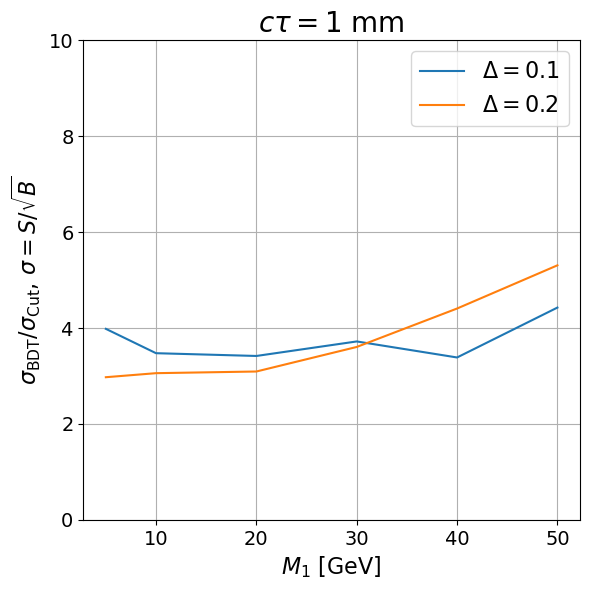

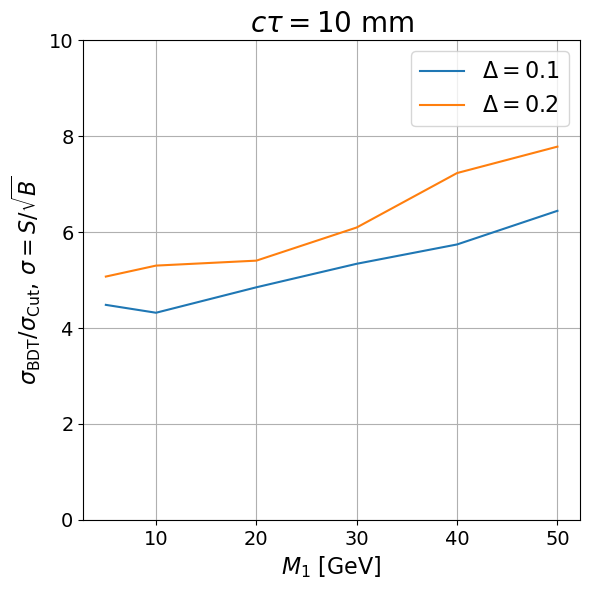

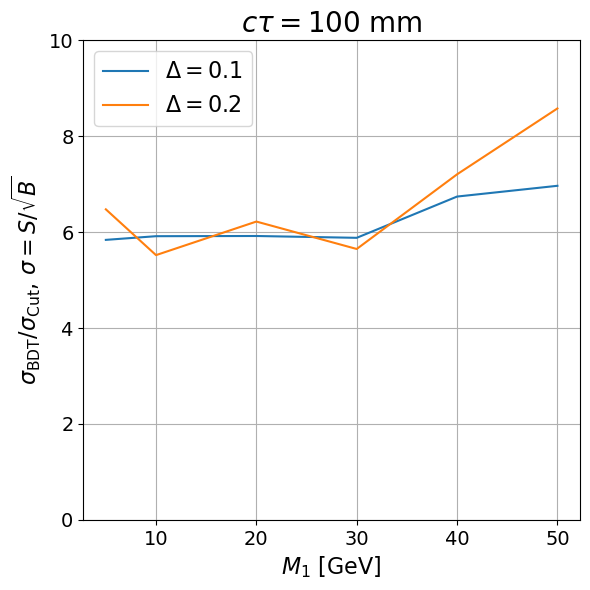

In [37]:
sigs_bdt = list(sig_tots_bdt.keys())
for ct in ctaus:
    plt.figure(figsize=(6,6))
    nb_cut = bkg_tot_cutBased
    nb_bdt = bkg_tots_bdt[ct]
    
    sigs = [s for s in sigs_bdt if s.split("_")[-1] == f"ctau-{ct}"]
    m1s = {0.1:[],0.2:[]}
    ratios = {0.1:[],0.2:[]}
    for s in sigs:
        mchi = float(s.split("_")[2].split("-")[1].replace("p","."))
        dmchi = float(s.split("_")[3].split("-")[1].replace("p","."))
        m1 = mchi-dmchi/2
        delta = dmchi/m1
        
        m1s[delta].append(m1)
        ratios[delta].append((sig_tots_bdt[s]/nb_bdt)/(sig_tots_cutBased[s]/nb_cut))
    for d in [0.1,0.2]:
        m1 = m1s[d]
        r = ratios[d]
        srt = np.argsort(np.array(m1))
        plt.plot(np.array(m1)[srt],np.array(r)[srt],label=rf"$\Delta = {d:.1f}$")
    plt.ylabel(r"$\sigma_\mathrm{BDT}/\sigma_\mathrm{Cut}$, $\sigma = S/\sqrt{B}$",fontsize=16)
    plt.legend(fontsize=16)
    plt.xlabel(r"$M_1$ [GeV]",fontsize=16)
    plt.title(rf"$c\tau = {ct}$ mm",fontsize=20)
    plt.ylim([0,10])
    plt.grid()
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"SoverRtB_comparison_ct-{ct}.pdf")

In [7]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

In [8]:
cutNames

{'all': 'No cuts',
 'hasVtx': 'Baseline Selection',
 'cut5': 'No b-tagged jets',
 'cut6': 'Leading jet |eta| < 2.4',
 'cut7': 'Leading jet pT > 80 GeV',
 'cut8': 'dPhi(MET,leading jet) > 1.5',
 'cut9': 'dPhi(MET,all jets) > 0.75',
 'cut10': 'OSSF',
 'cut11': 'Vertex chi2/df < 3',
 'cut12': 'dPhi(MET,vtx) < 1',
 'cut13': 'm(ee) < 20',
 'cut14': 'dR(ee) < 1.0',
 'cut15': 'minDxy > 0.01',
 'cut16': 'minDxy > 0.03',
 'cut17': 'dPhi(MET,vtx) < 0.5'}

In [9]:
if not os.path.isdir("plots/cutflows/"):
    os.makedirs("plots/cutflows/")

# Signal

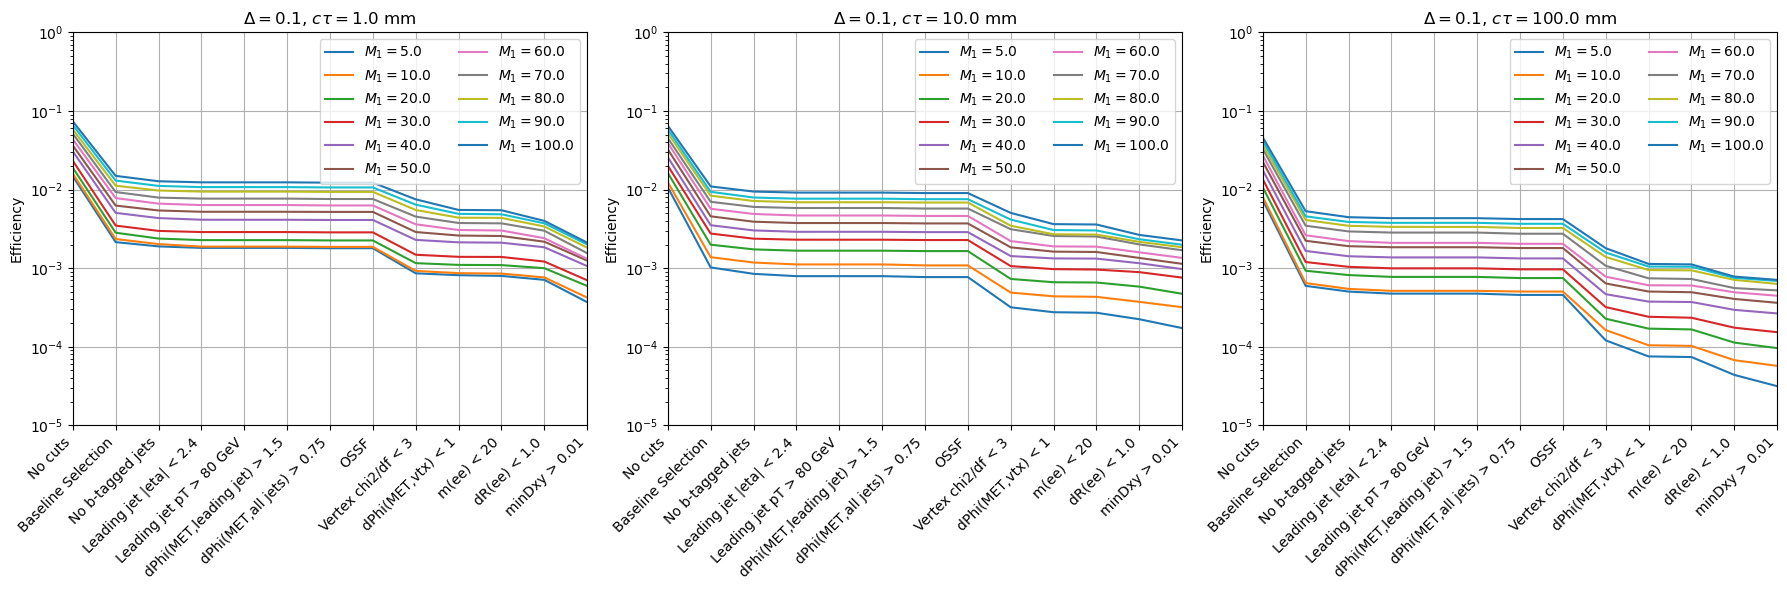

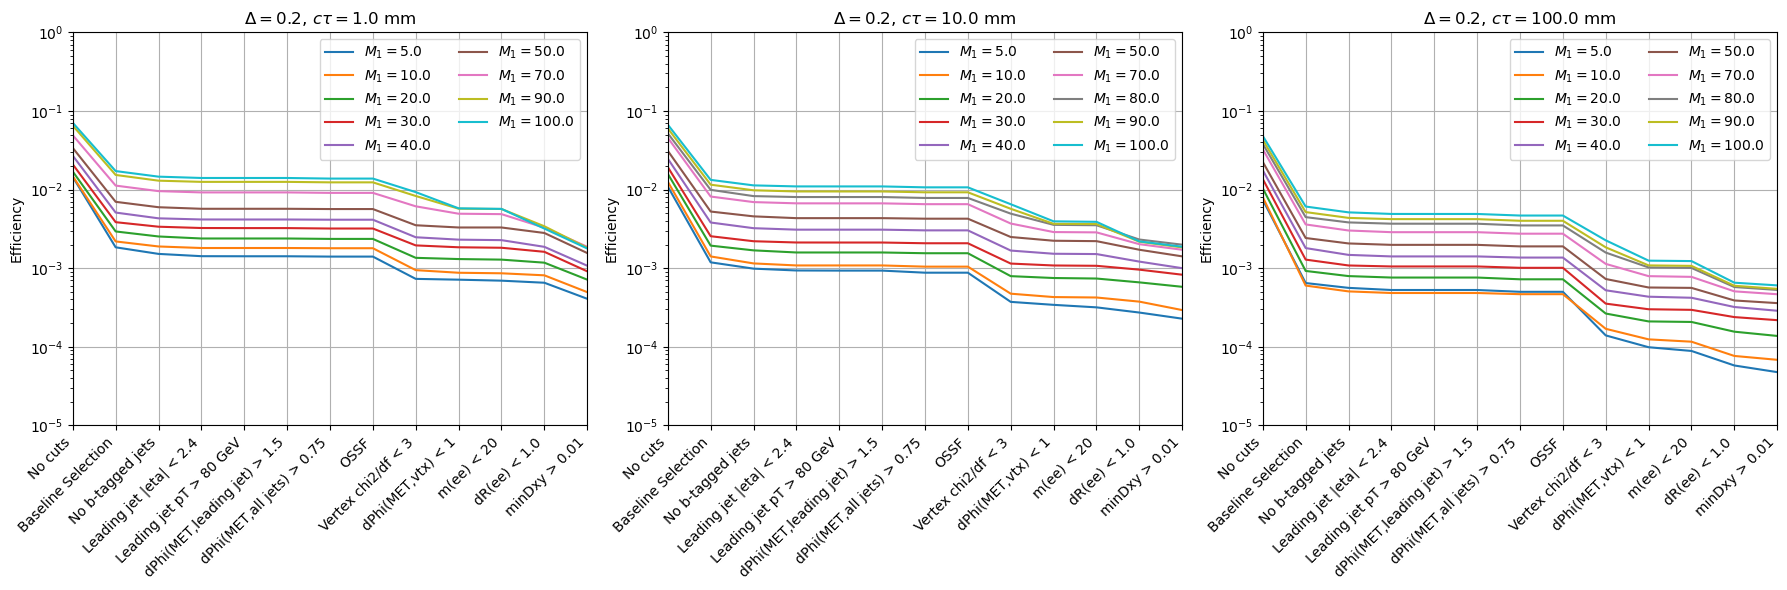

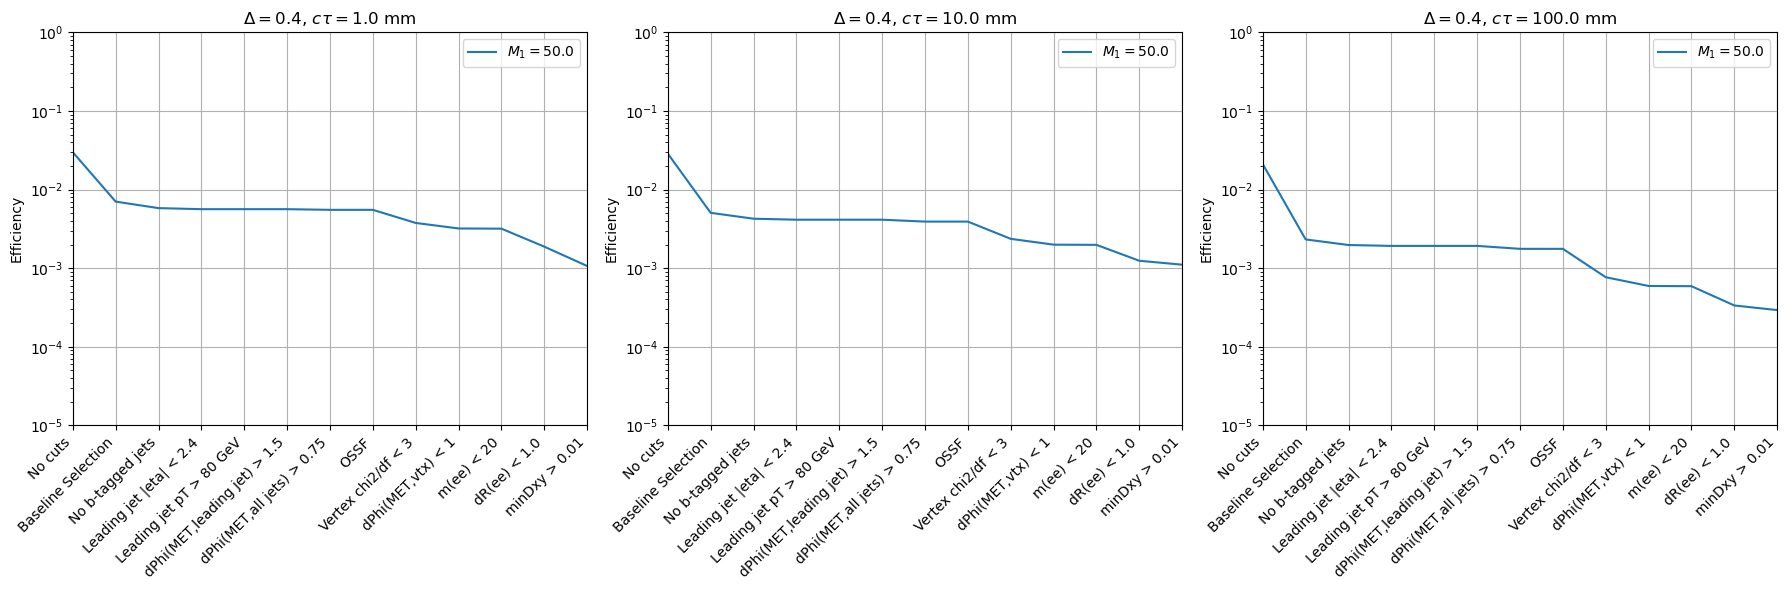

In [6]:
# signal efficiencies by delta/ctau
cf_s = sig['cutflow']
ct_s = sig['cutflow_cts']
desc = sig['cutDesc']
for delta in deltas:
    all_m1s = sorted(list(set(si[si.delta==delta].m1)))
    #plt.figure(figsize=(12,12))
    ctaus = sorted(list(set(si[si.delta==delta].ctau)))
    fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(si[(si.delta==delta)&(si.ctau==ct)].m1)))
        plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
        for m1 in m1s:
            pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
            effs = [cf_s[pt][cut] for cut in cuts]
            plt.plot(np.arange(len(cuts)),effs,label=r"$M_1 = {0}$".format(m1),color=f"C{all_m1s.index(m1)}")
        plt.legend(loc='upper right',ncol=2)
        plt.ylim([0.00001,1])
        plt.xlim([0,len(cuts)-1])
        plt.yscale('log')
        plt.ylabel("Efficiency")
        plt.xticks(ticks=np.arange(len(cuts)),labels=[cutNames[c] for c in cuts],rotation=45,ha='right')
        plt.grid()
    plt.tight_layout()
    plt.savefig(f"plots/cutflows/signal_effs_delta{delta:.1f}.pdf")
    #plt.close()

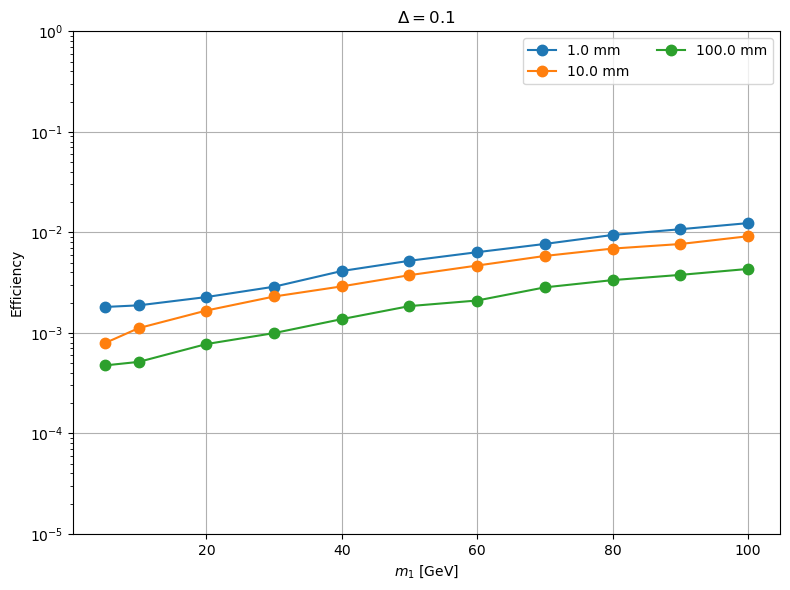

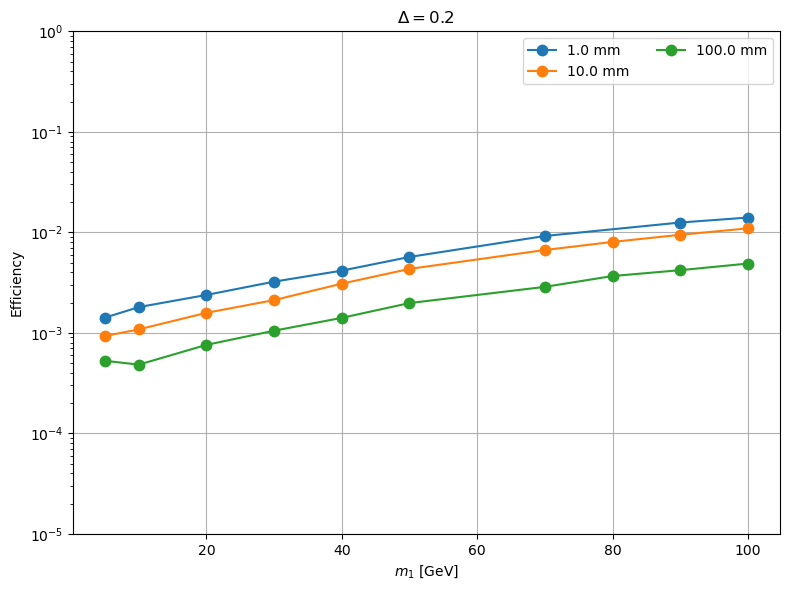

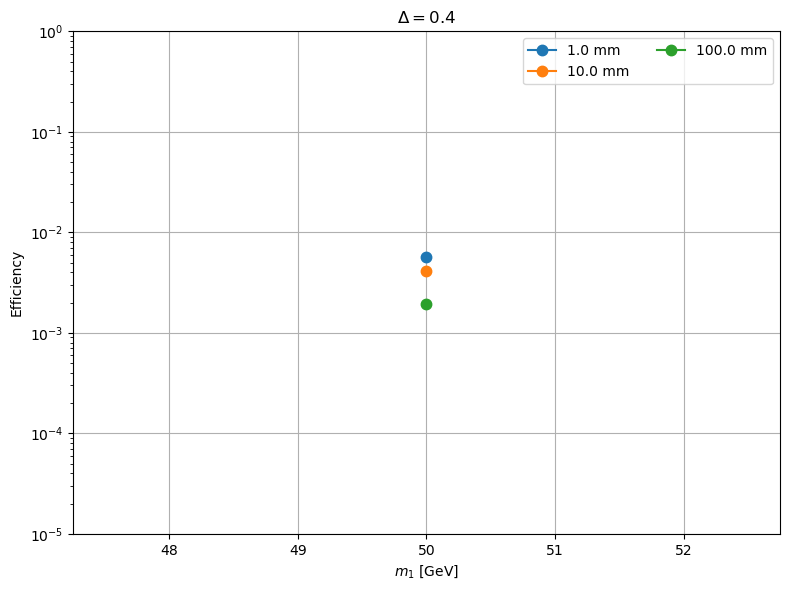

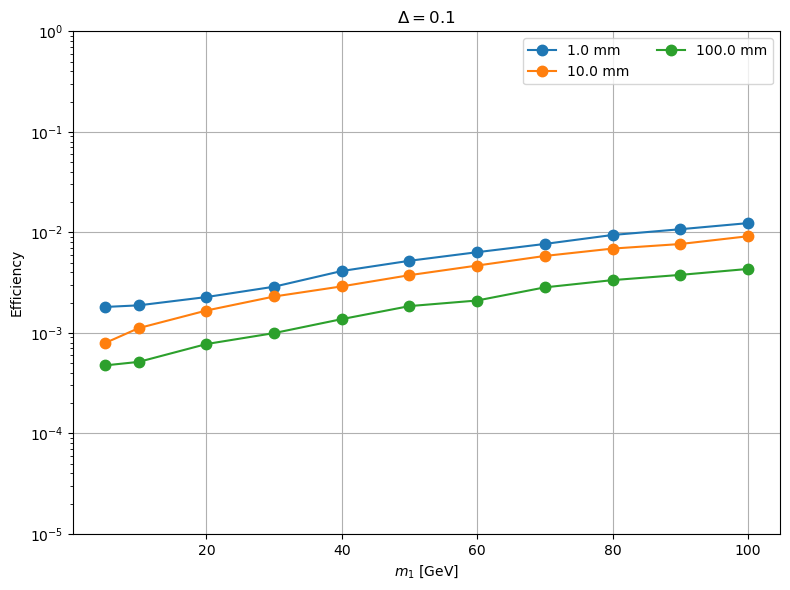

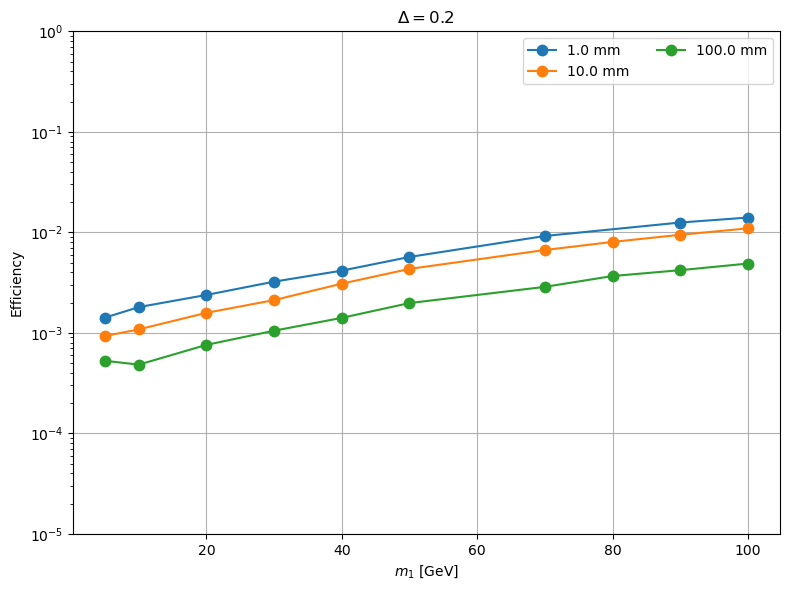

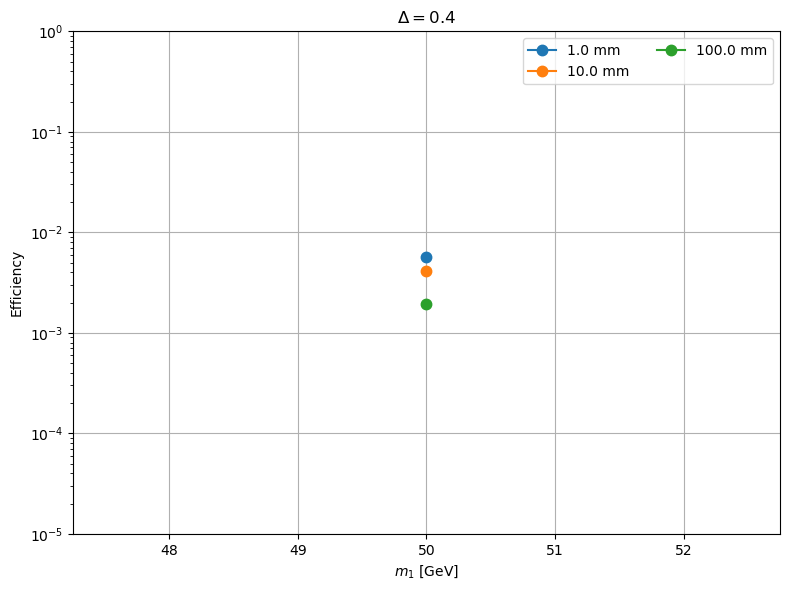

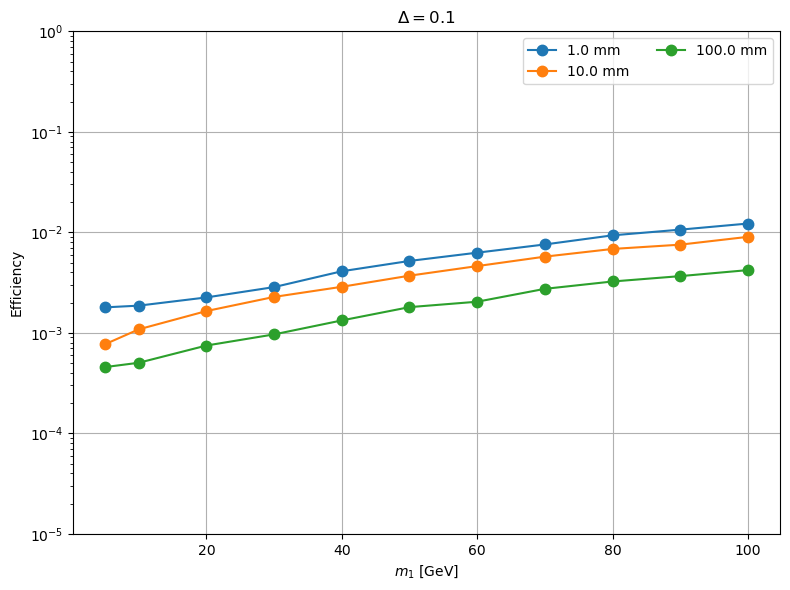

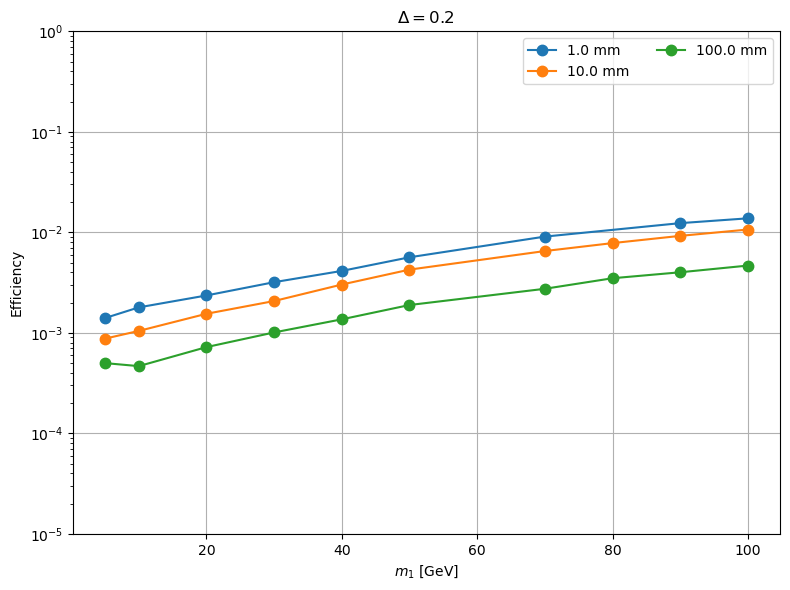

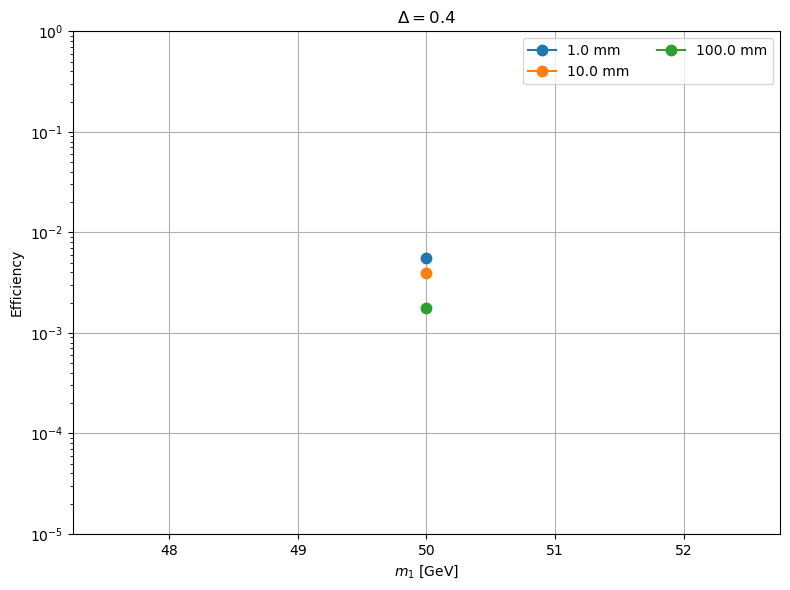

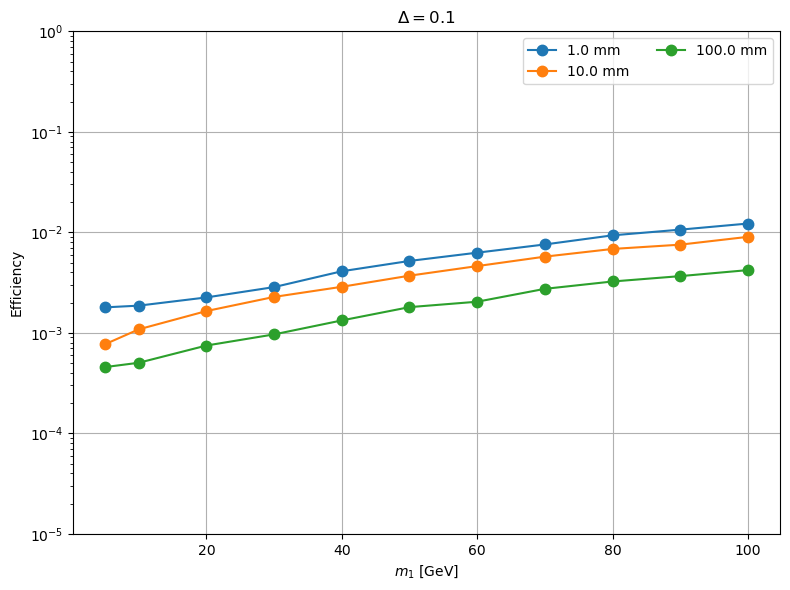

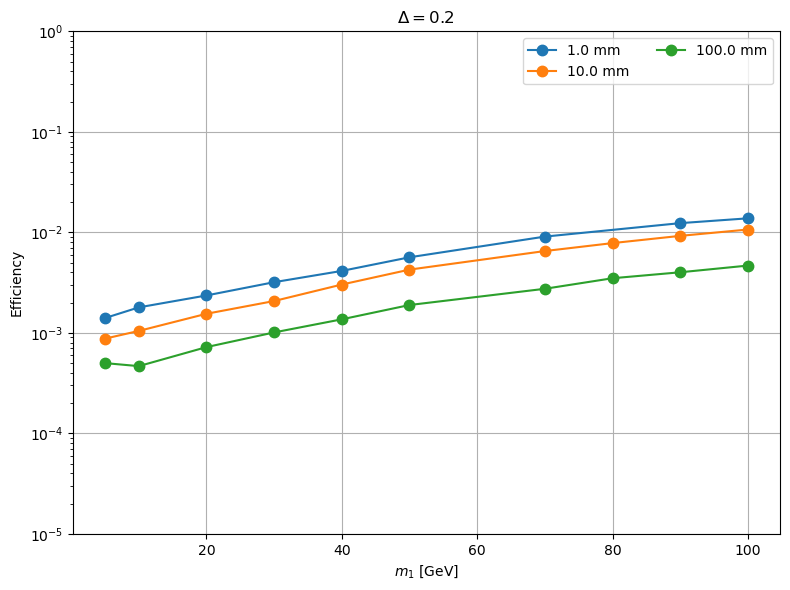

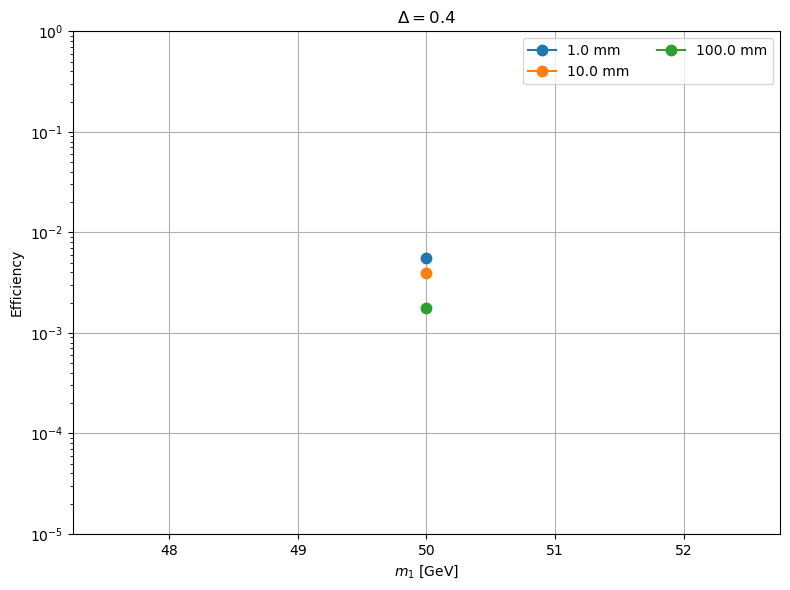

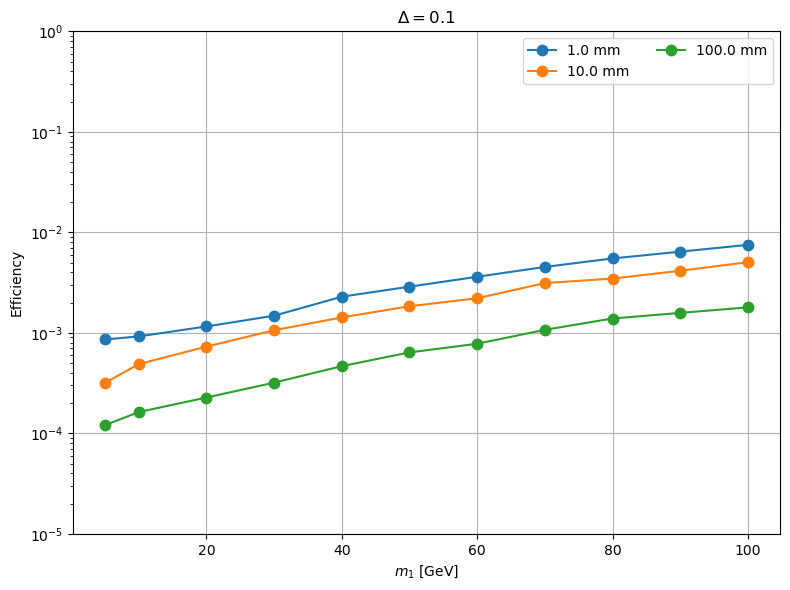

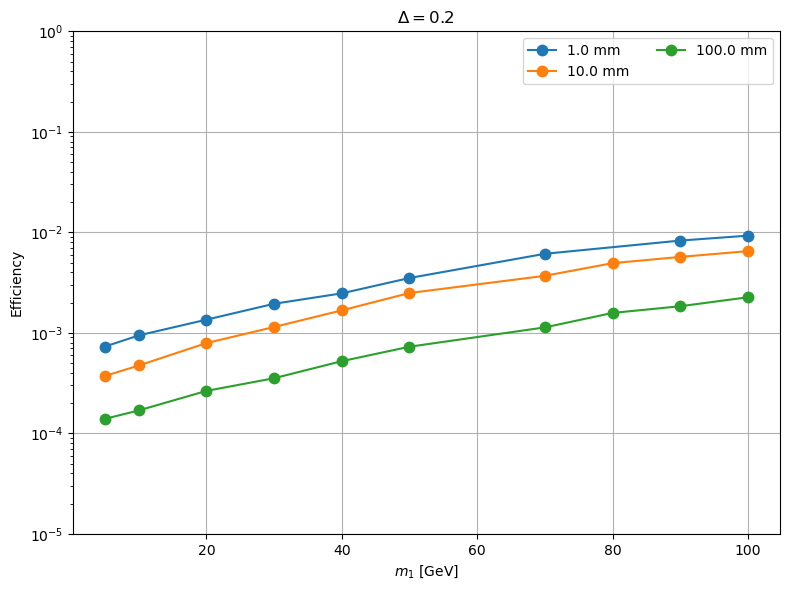

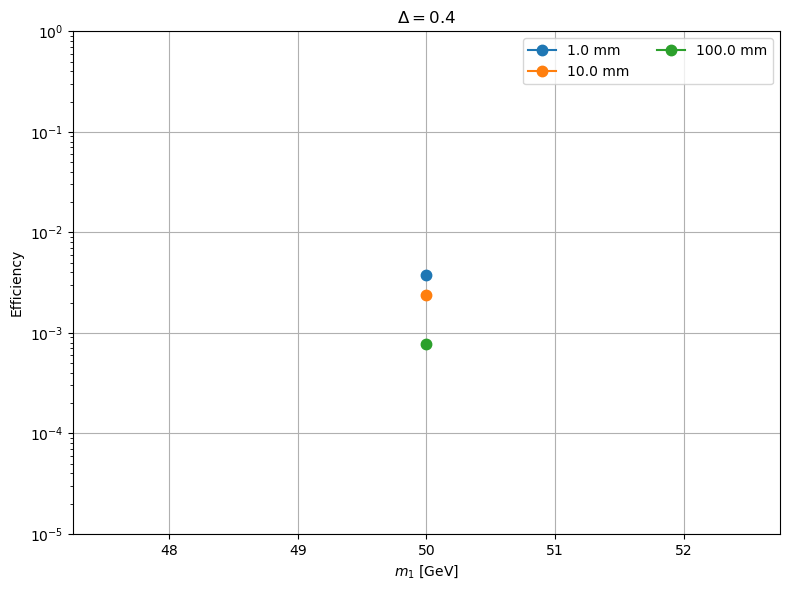

In [7]:
# signal efficiencies by m1 (ctau overlay) on second to last cut
cf_s = sig['cutflow']
ct_s = sig['cutflow_cts']
desc = sig['cutDesc']
for cut in ['cut7','cut8','cut9','cut10','cut11']:
    for delta in deltas:
        all_m1s = sorted(list(set(si[si.delta==delta].m1)))
        plt.figure(figsize=(8,6))
        ctaus = sorted(list(set(si[si.delta==delta].ctau)))
        plt.title(r"$\Delta = {0:.1f}$".format(delta))
        for i,ct in enumerate(ctaus):
            m1s = sorted(list(set(si[(si.delta==delta)&(si.ctau==ct)].m1)))
            effs = []
            for m1 in m1s:
                pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                effs.append(cf_s[pt][cut])
            plt.plot(m1s,effs,label=f"{ct} mm",marker='.',markersize=15)
        plt.legend(loc='upper right',ncol=2)
        plt.ylim([0.00001,1])
        plt.yscale('log')
        plt.ylabel("Efficiency")
        plt.xlabel("$m_1$ [GeV]")
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"plots/cutflows/signal_{cut}_effs_delta{delta:.1f}.pdf")
        #plt.close()

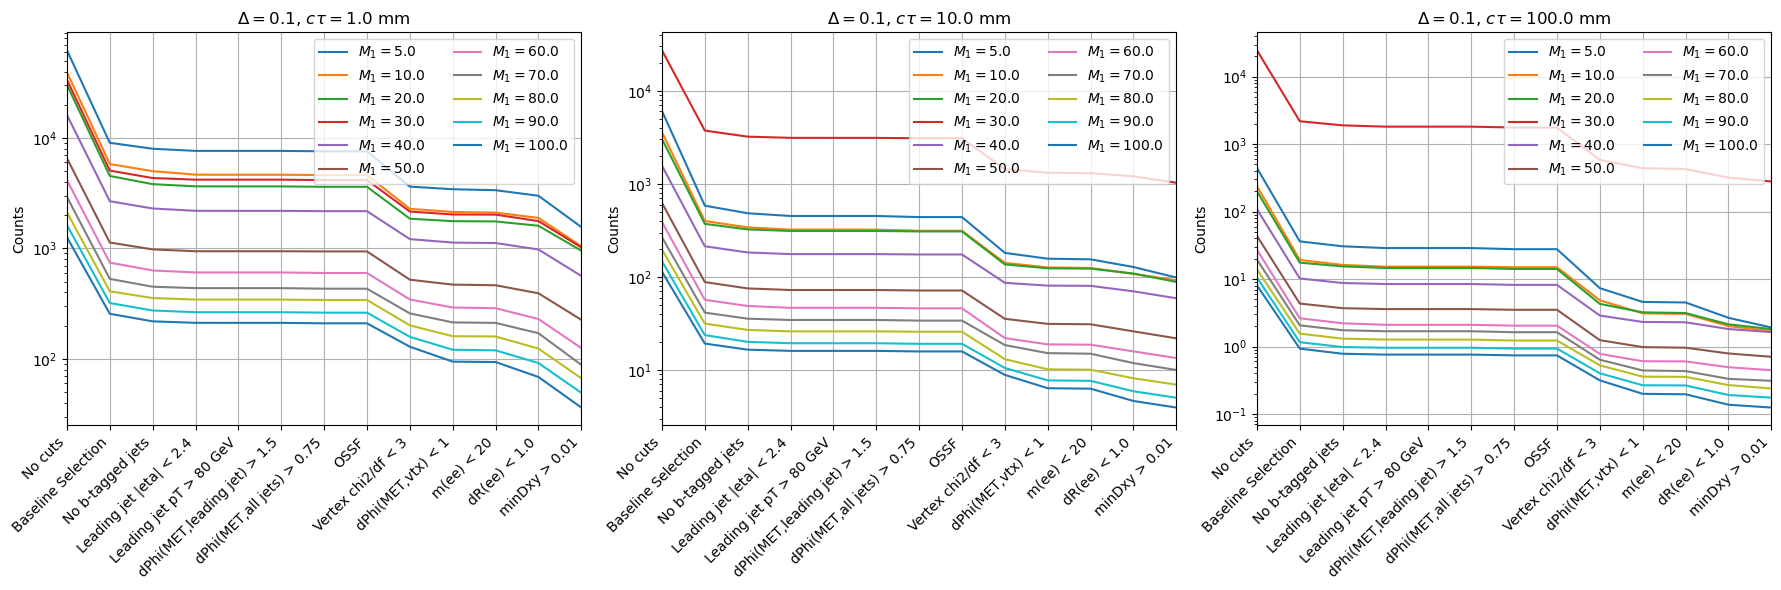

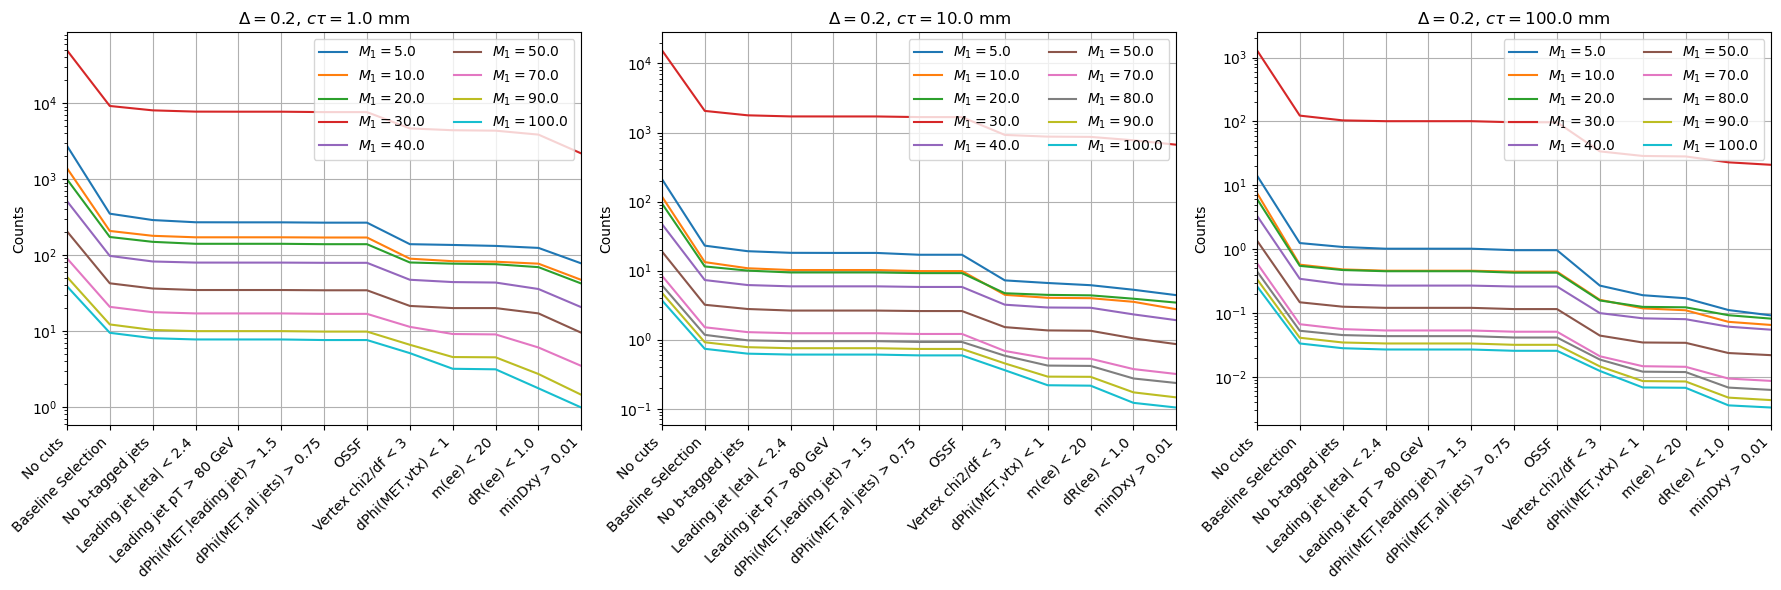

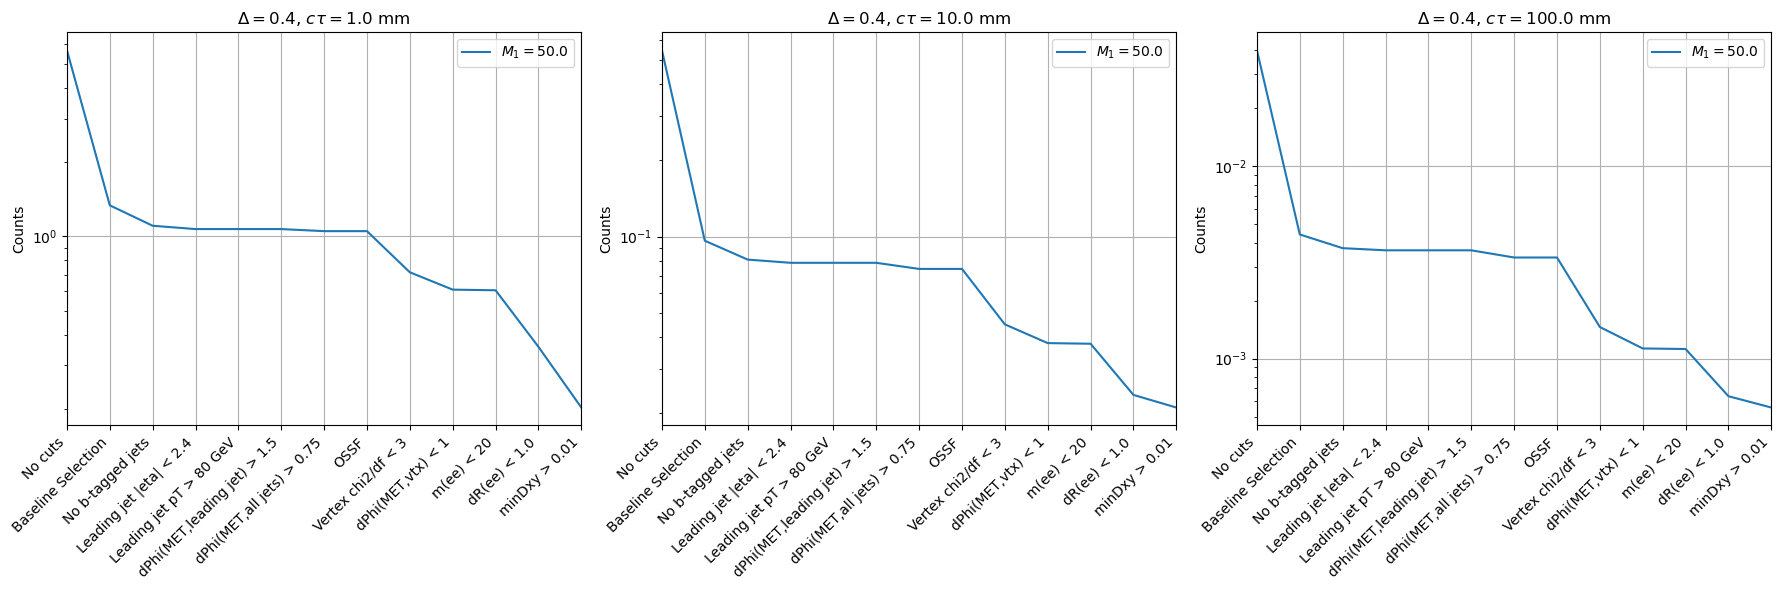

In [8]:
# signal counts by delta/ctau
cf_s = sig['cutflow']
ct_s = sig['cutflow_cts']
desc = sig['cutDesc']
for delta in deltas:
    all_m1s = sorted(list(set(si[si.delta==delta].m1)))
    #plt.figure(figsize=(12,12))
    ctaus = sorted(list(set(si[si.delta==delta].ctau)))
    fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(si[(si.delta==delta)&(si.ctau==ct)].m1)))
        plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
        for m1 in m1s:
            pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
            effs = [ct_s[pt][cut] for cut in cuts]
            plt.plot(np.arange(len(cuts)),effs,label=r"$M_1 = {0}$".format(m1),color=f"C{all_m1s.index(m1)}")
        plt.legend(loc='upper right',ncol=2)
        #plt.ylim([0.00001,1])
        plt.xlim([0,len(cuts)-1])
        plt.yscale('log')
        plt.ylabel("Counts")
        plt.xticks(ticks=np.arange(len(cuts)),labels=[cutNames[c] for c in cuts],rotation=45,ha='right')
        plt.grid()
    plt.tight_layout()
    plt.savefig(f"plots/cutflows/signal_counts_delta{delta:.1f}.pdf")
    #plt.close()

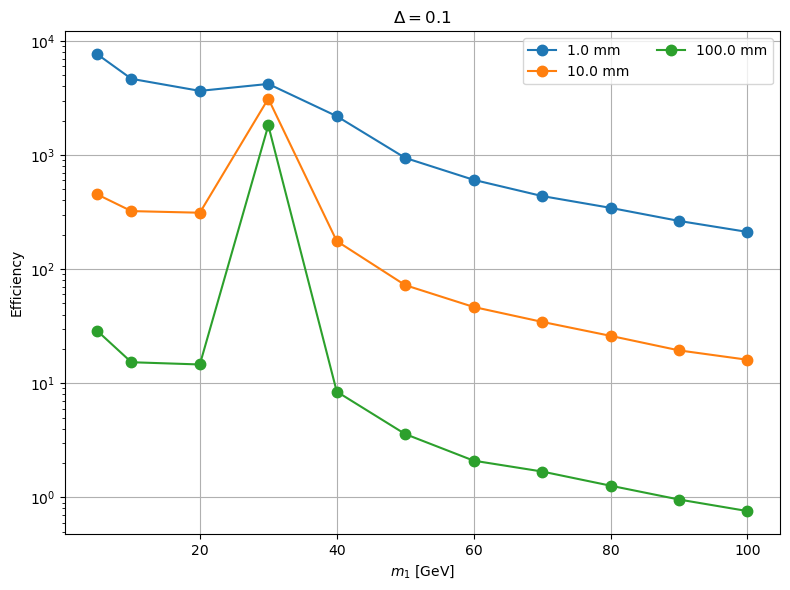

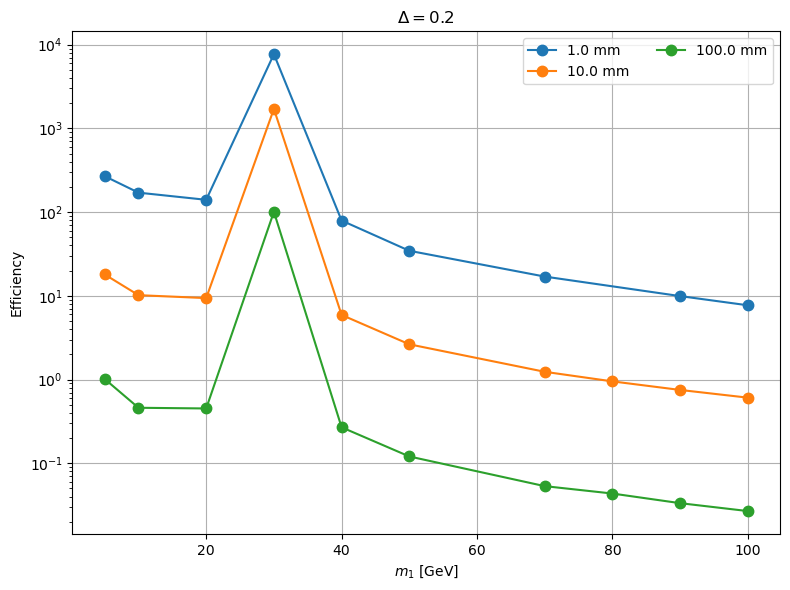

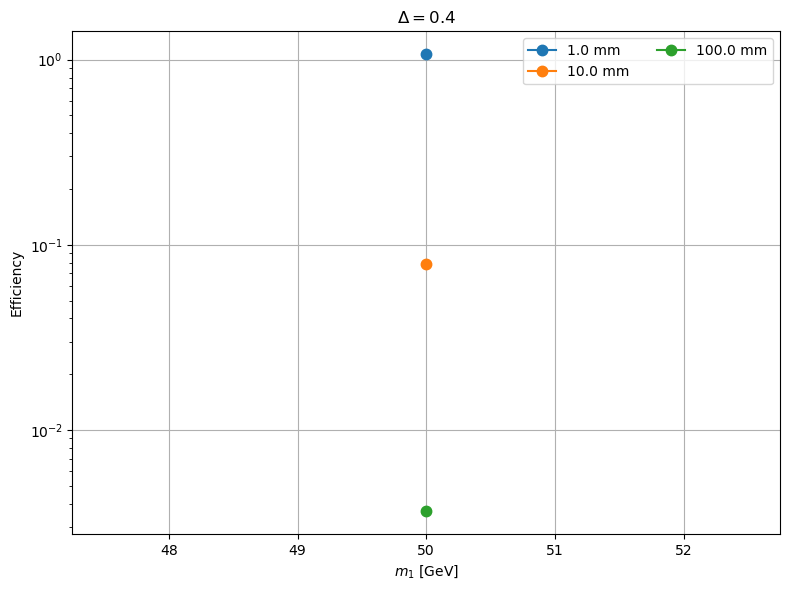

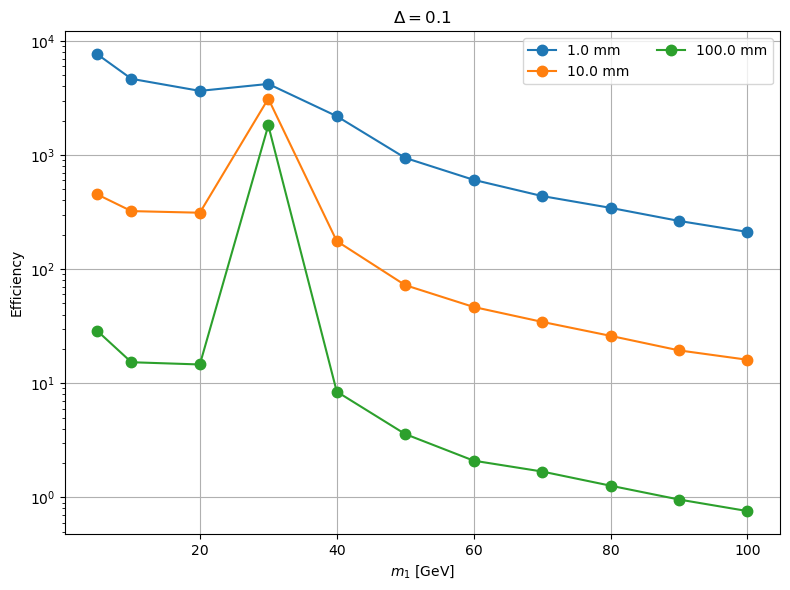

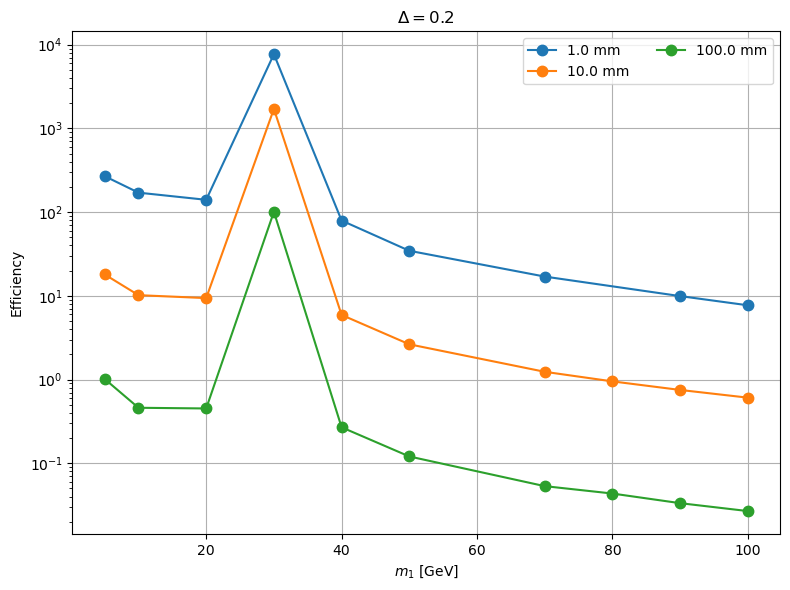

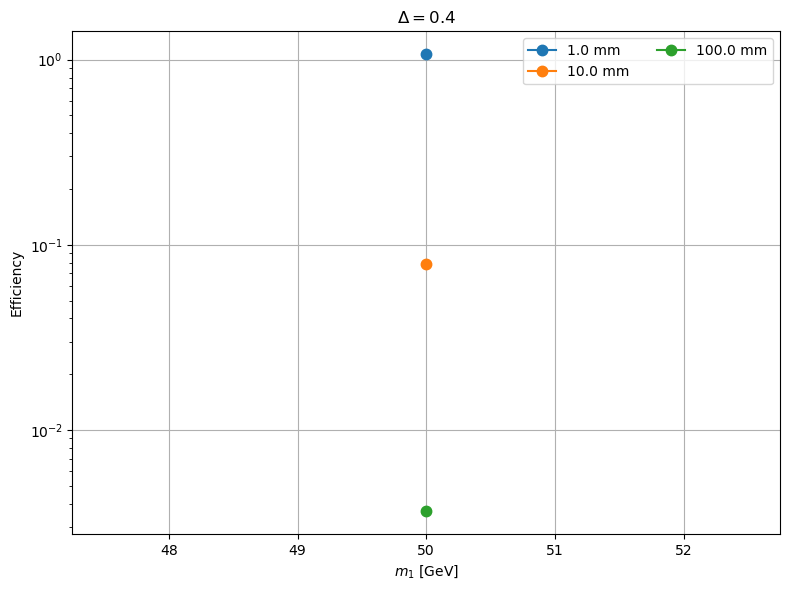

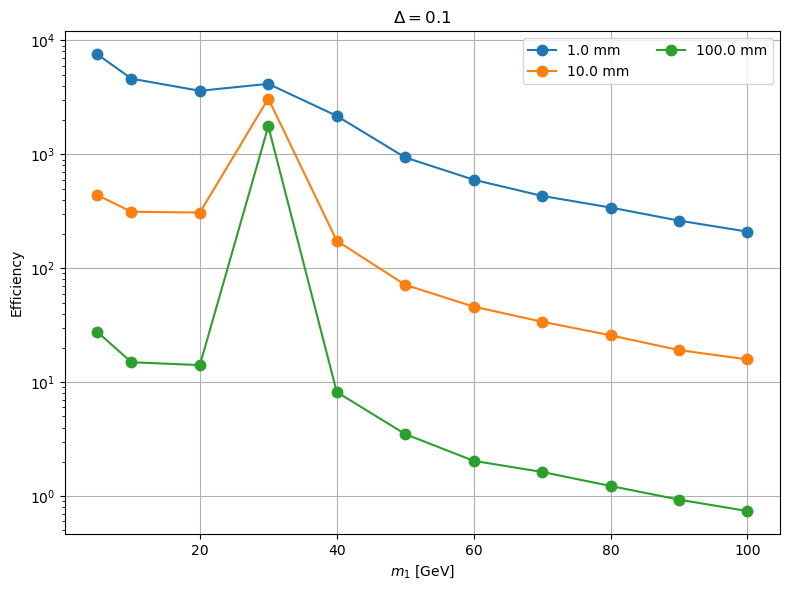

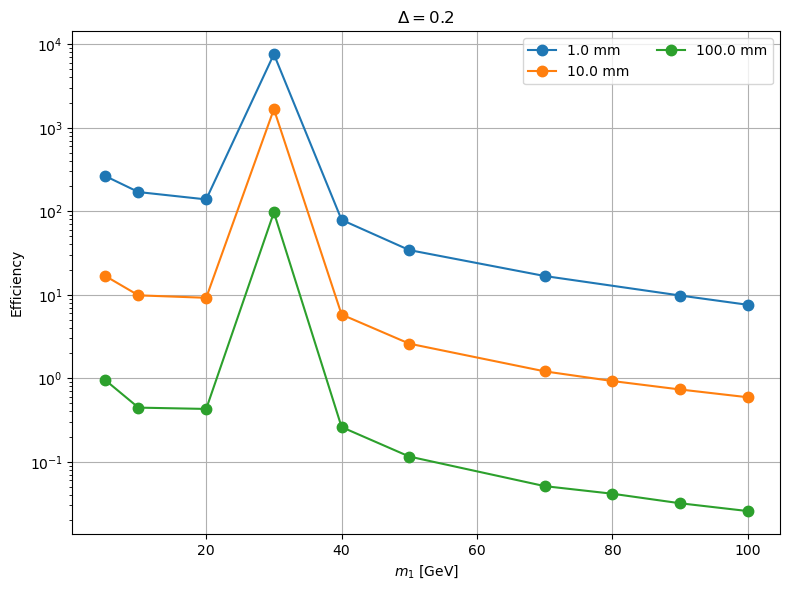

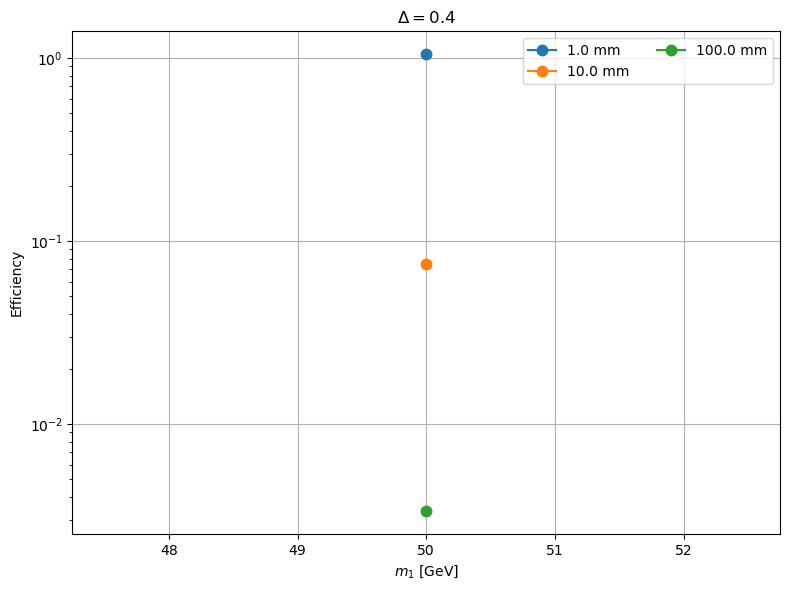

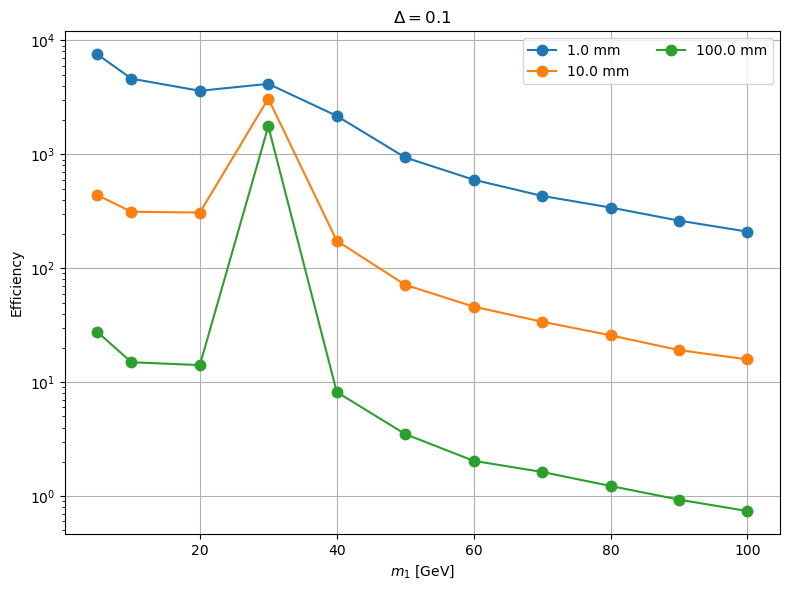

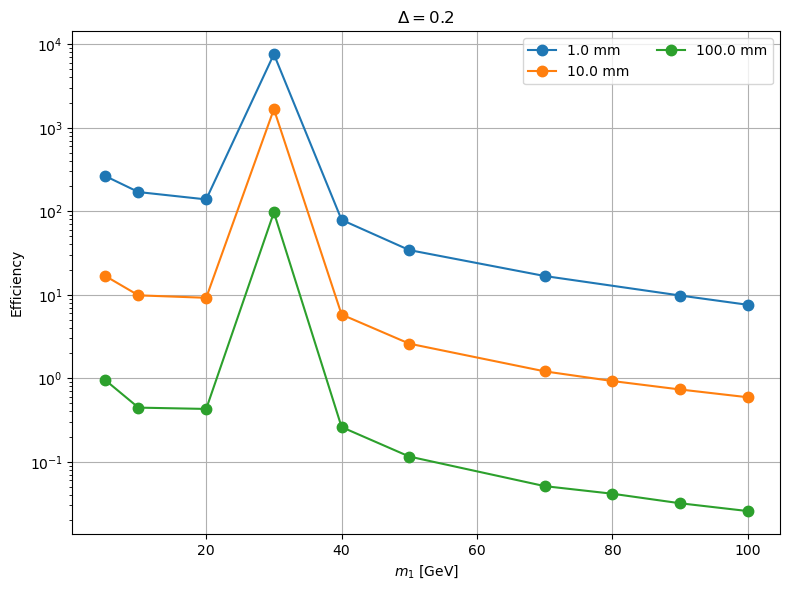

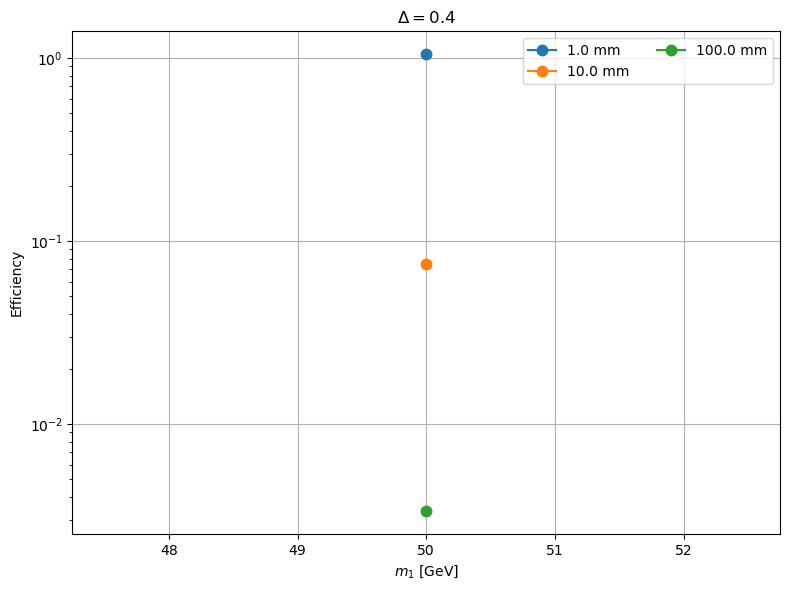

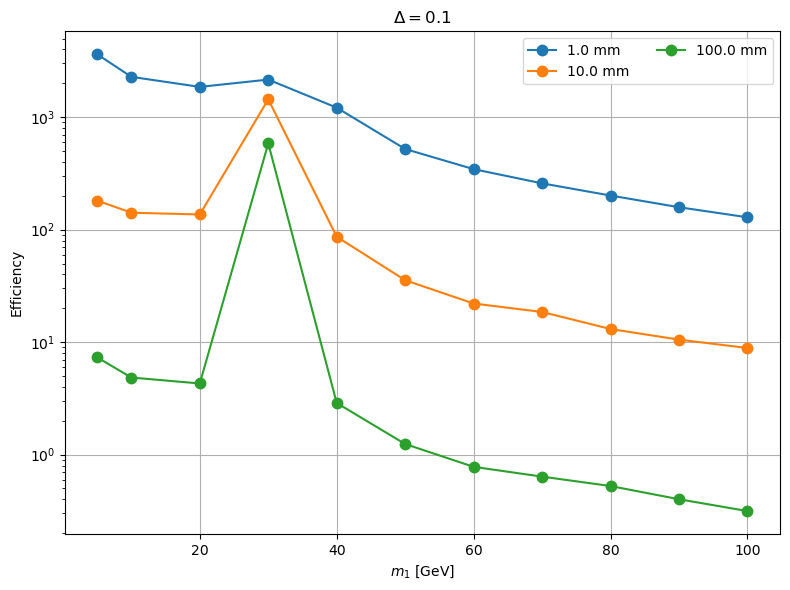

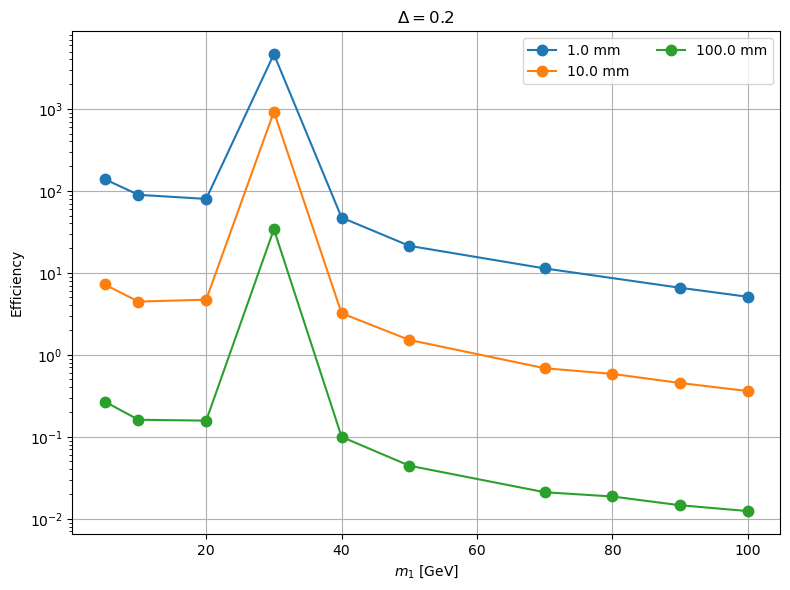

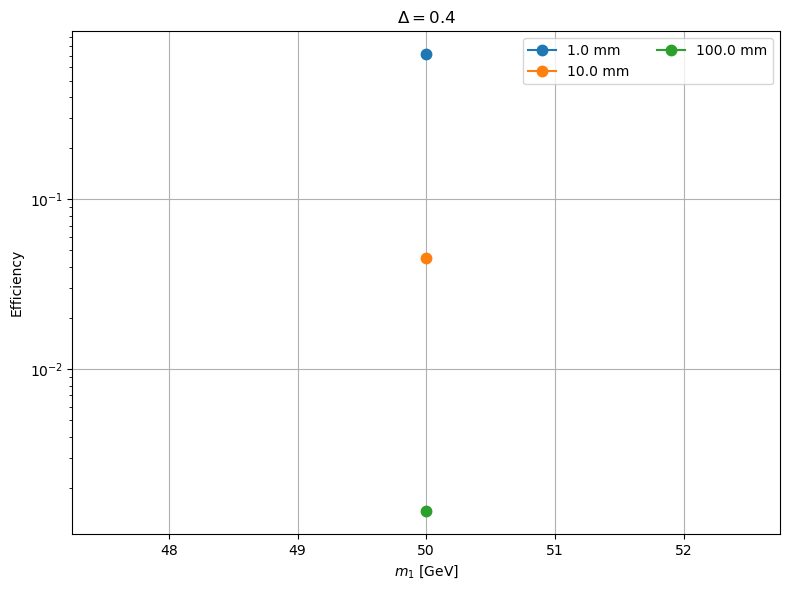

In [9]:
# signal counts by m1 (ctau overlay) on second to last cut
cf_s = sig['cutflow']
ct_s = sig['cutflow_cts']
desc = sig['cutDesc']
for cut in ["cut7","cut8","cut9","cut10","cut11"]:
    for delta in deltas:
        all_m1s = sorted(list(set(si[si.delta==delta].m1)))
        plt.figure(figsize=(8,6))
        ctaus = sorted(list(set(si[si.delta==delta].ctau)))
        plt.title(r"$\Delta = {0:.1f}$".format(delta))
        for i,ct in enumerate(ctaus):
            m1s = sorted(list(set(si[(si.delta==delta)&(si.ctau==ct)].m1)))
            effs = []
            for m1 in m1s:
                pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                effs.append(ct_s[pt][cut])
            plt.plot(m1s,effs,label=f"{ct} mm",marker='.',markersize=15)
        plt.legend(loc='upper right',ncol=2)
        #plt.ylim([0.00001,1])
        plt.yscale('log')
        plt.ylabel("Efficiency")
        plt.xlabel("$m_1$ [GeV]")
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"plots/cutflows/signal_{cut}_counts_delta{delta:.1f}.pdf")
        #plt.close()

# Bkg

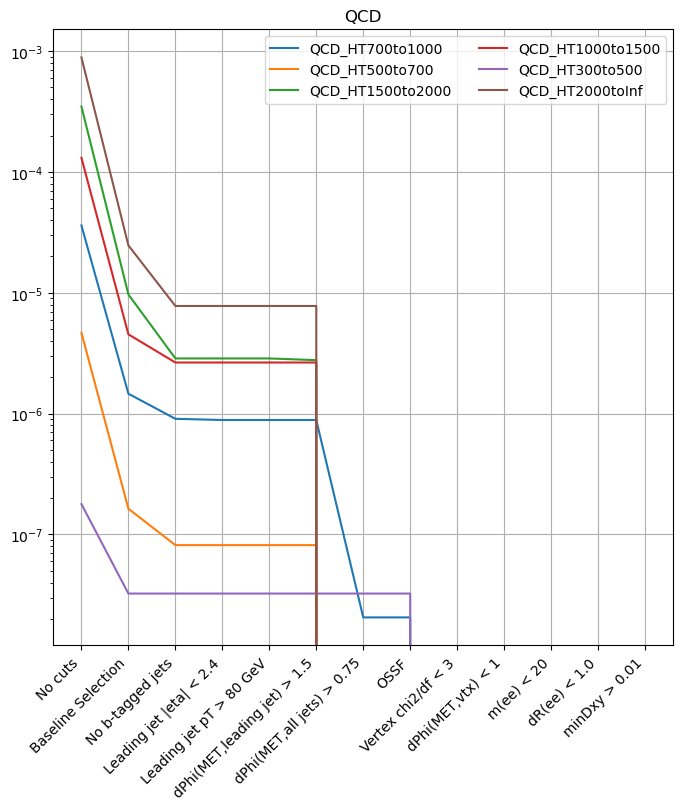

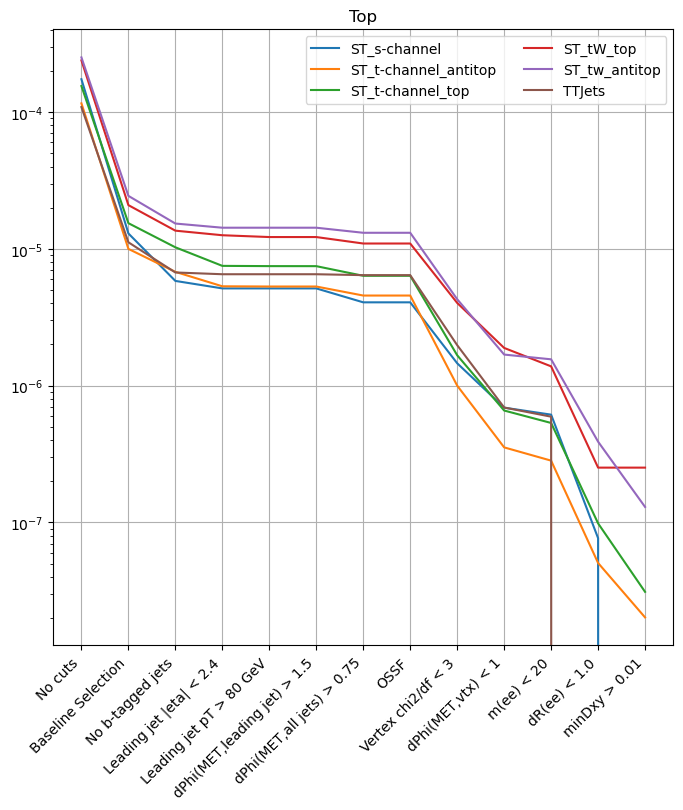

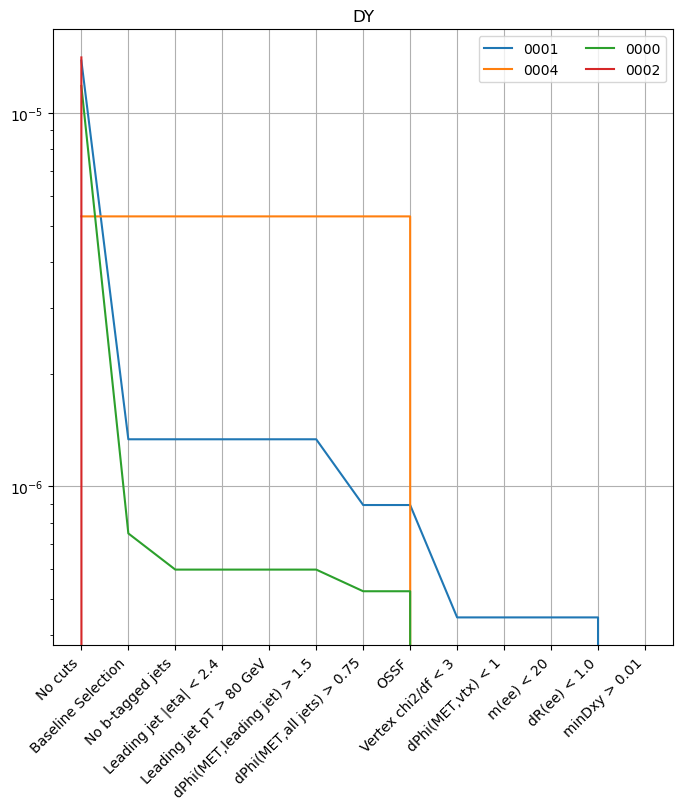

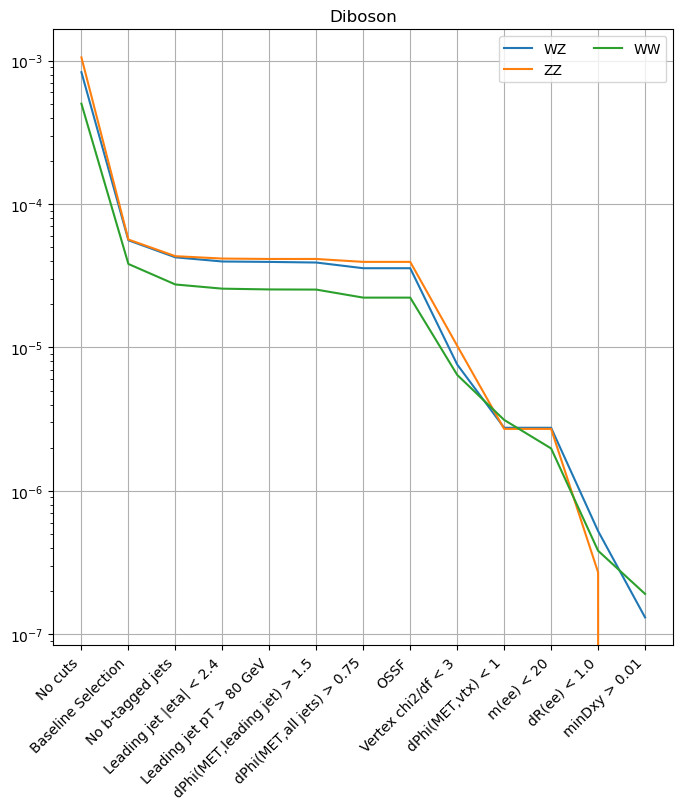

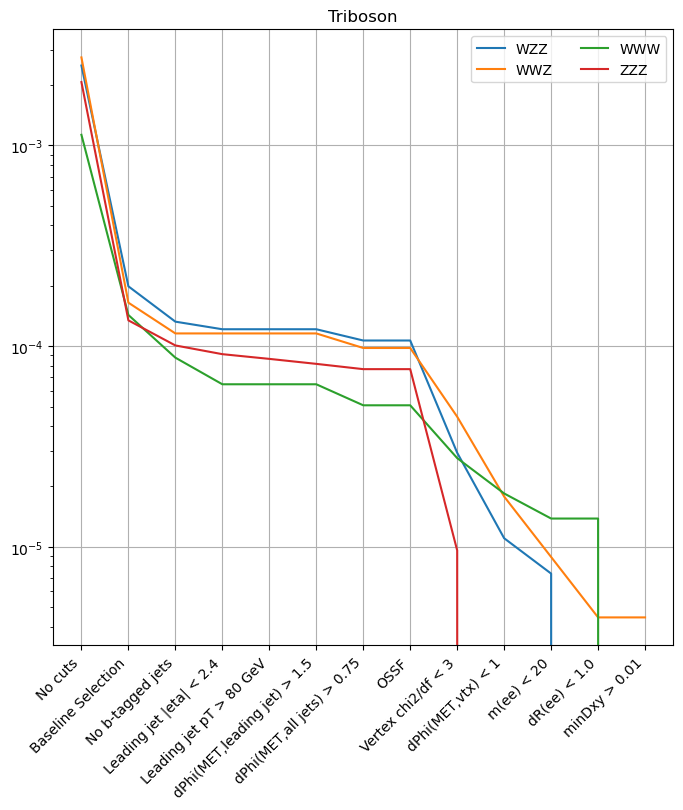

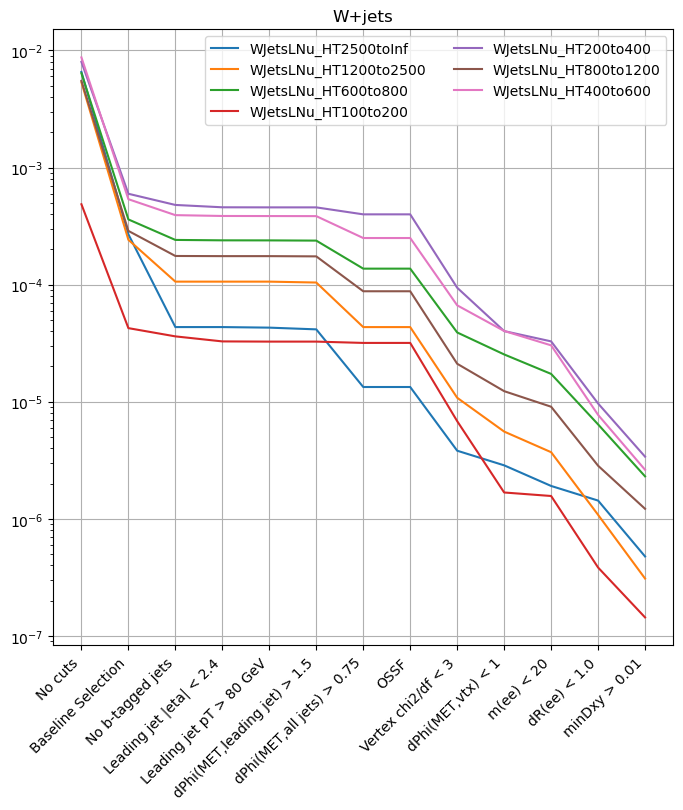

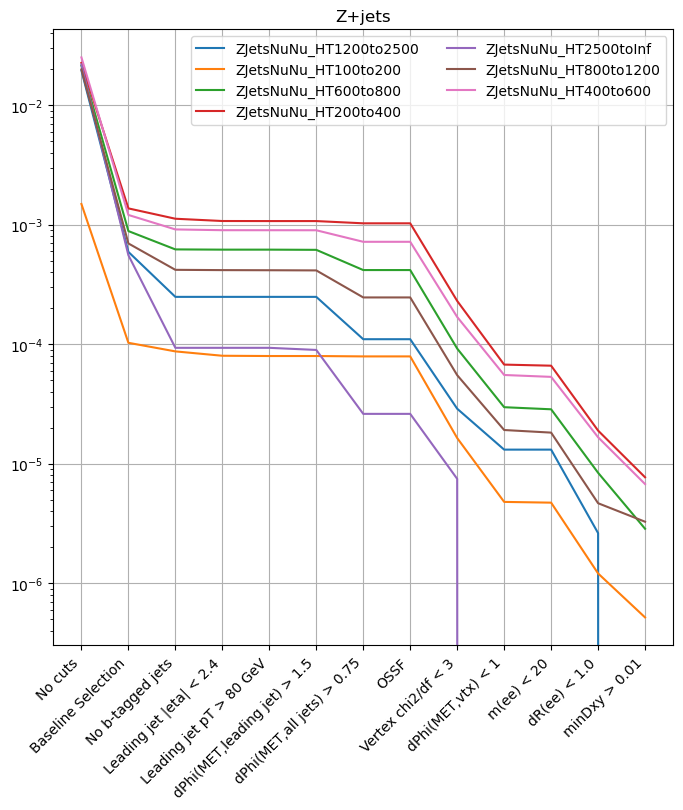

In [11]:
# bkg efficiencies in sub-samples (e.g. HT bins)
for b in bkg['cutflow'].keys():
    cfbs = bkg['cutflow'][b]
    plt.figure(figsize=(8,8))
    plt.title(b)
    subsamples = list(cfbs.keys())
    for bkg_pt in subsamples:
        cf = cfbs[bkg_pt]
        effs = [cf[c] for c in cuts]
        plt.plot(np.arange(len(effs)),effs,label=bkg_pt[9:])
    #plt.ylim([1e-12,1])
    plt.yscale('log')
    plt.legend(loc='upper right',ncol=2)
    plt.grid()
    #plt.xlabel("Cut Number")
    plt.xticks(ticks=np.arange(len(cuts)),labels=[cutNames[c] for c in cuts],rotation=45,ha='right')
    plt.savefig(f"plots/cutflows/bkg_{b}_cutflow.pdf")
    #plt.close()

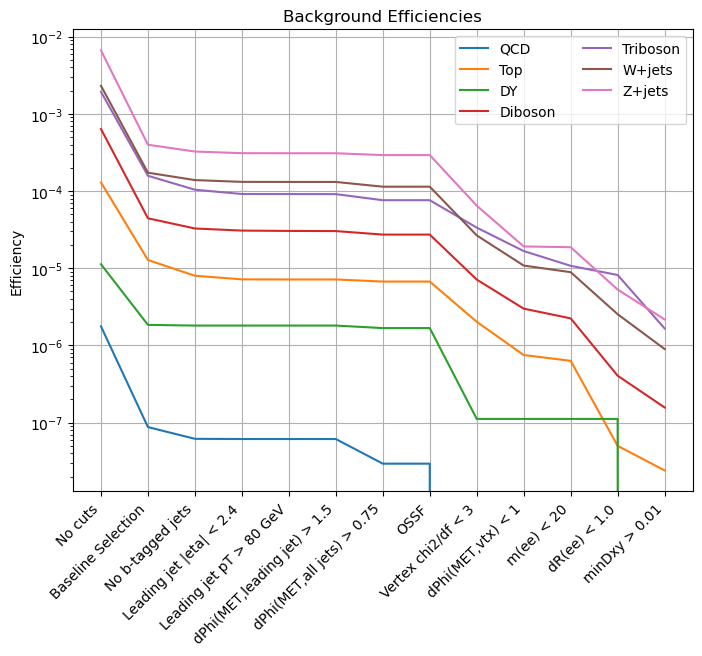

In [12]:
# bkg efficiencies summed over sub-samples
plt.figure(figsize=(8,6))
plt.title("Background Efficiencies")
for b in bkg['cutflow'].keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])
plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()
plt.xticks(ticks=np.arange(len(cuts)),labels=[cutNames[c] for c in cuts],rotation=45,ha='right')
plt.savefig(f"plots/cutflows/bkg_combined_cutflow.pdf")

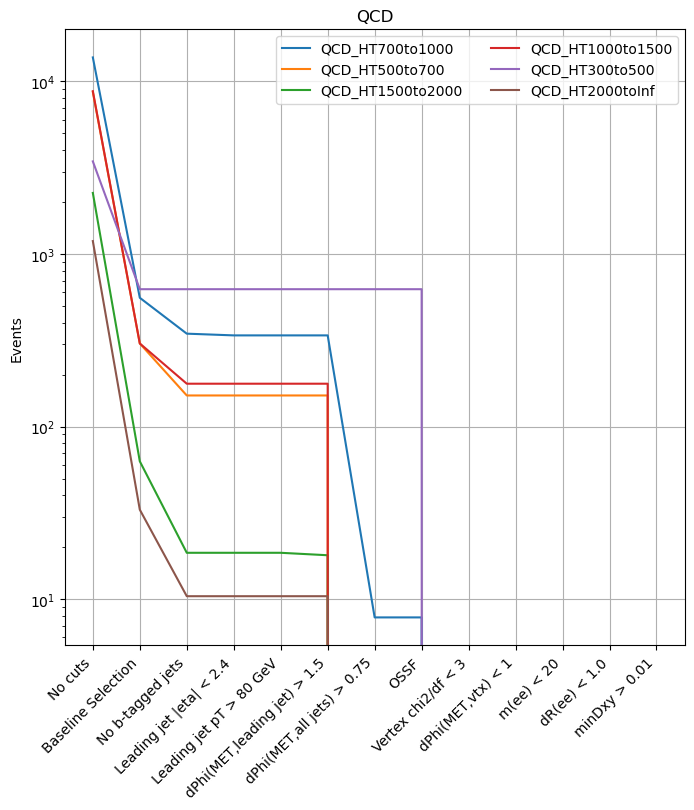

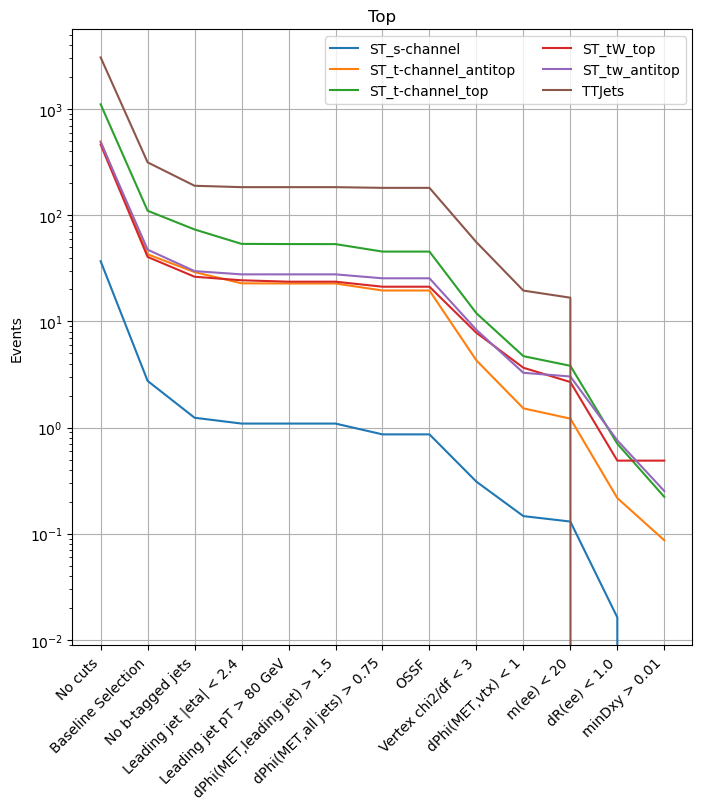

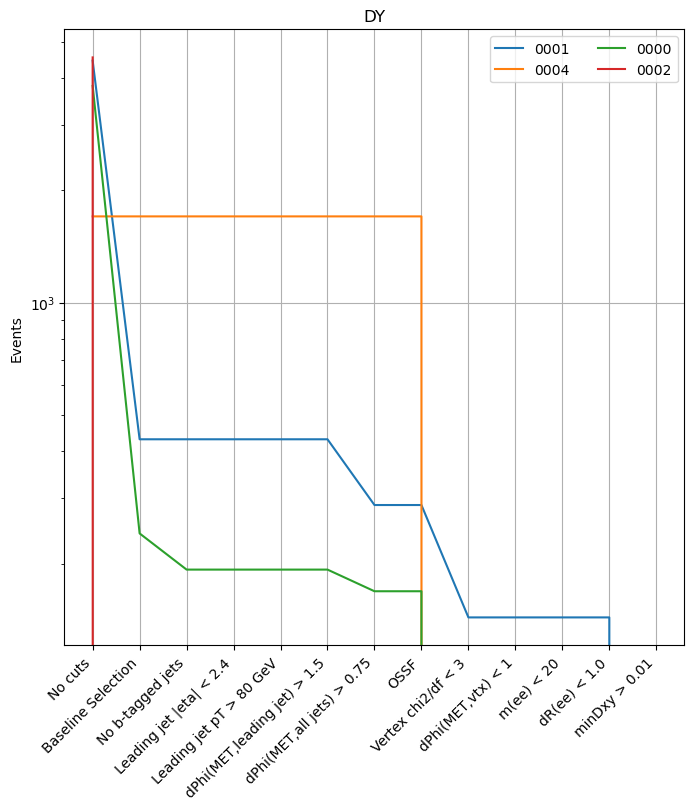

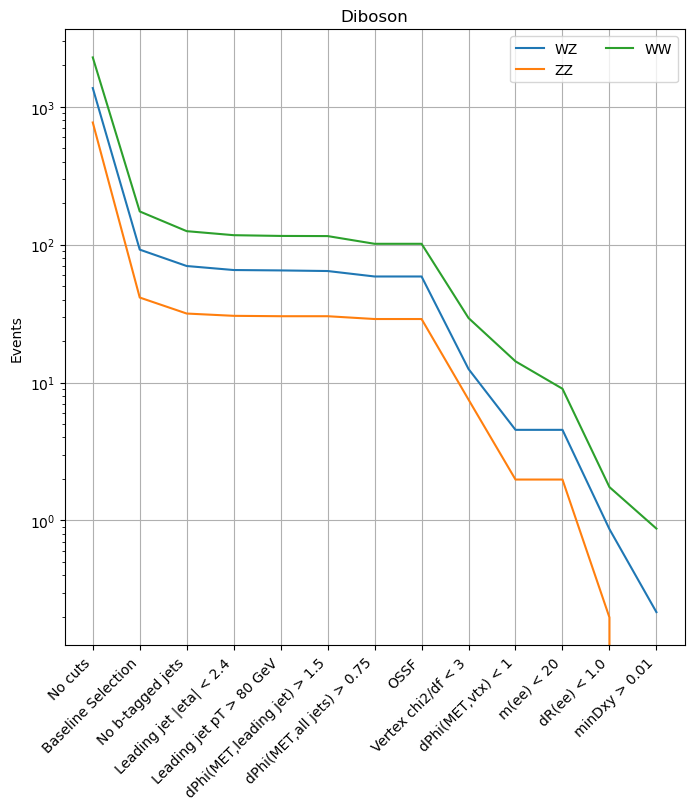

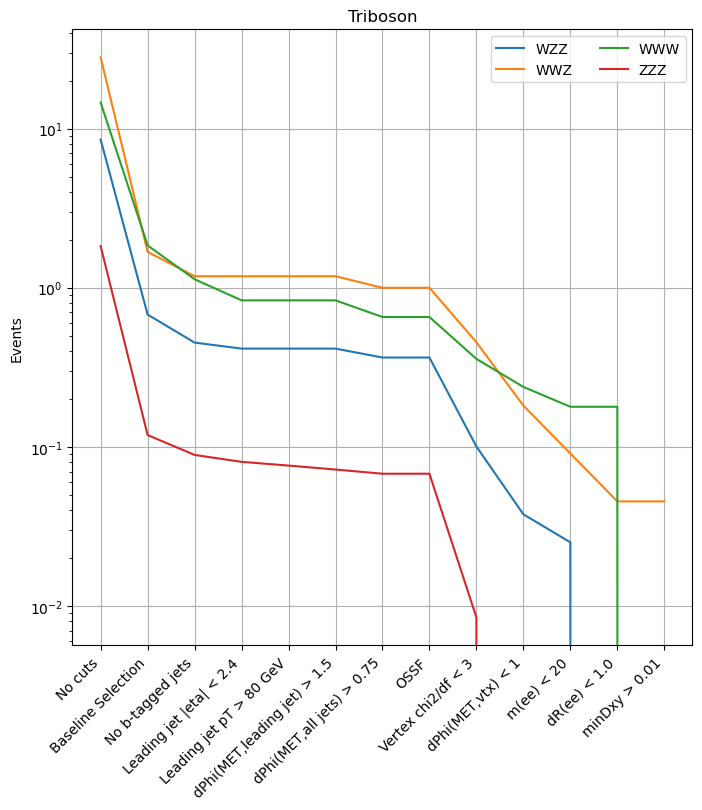

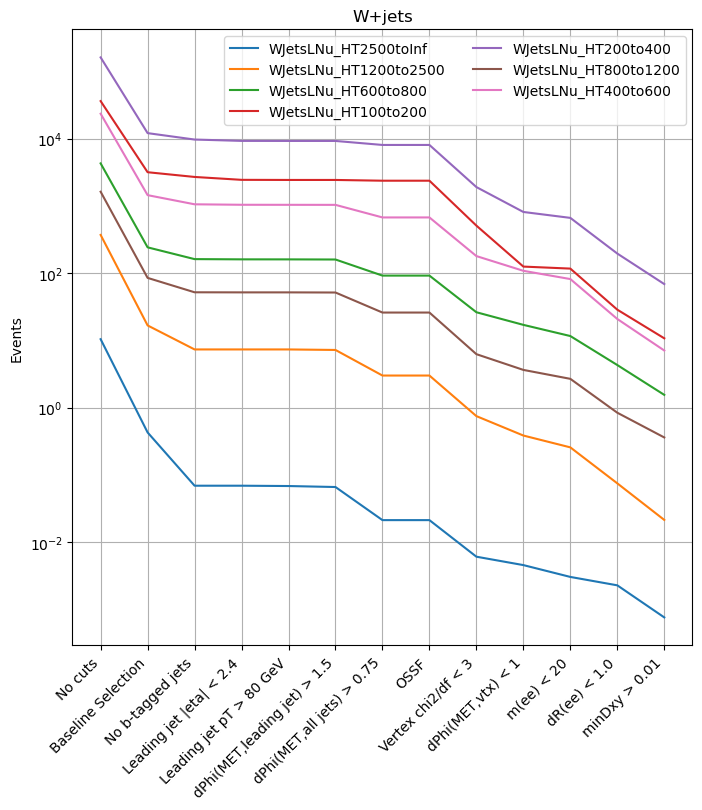

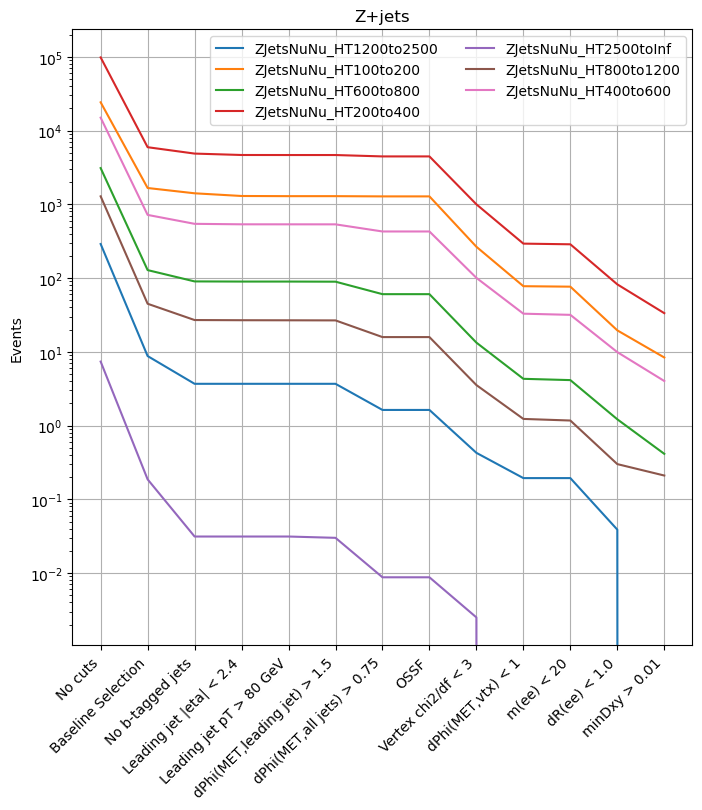

In [13]:
# bkg counts
for b in bkg['cutflow'].keys():
    cfbs = bkg['cutflow_cts'][b]
    plt.figure(figsize=(8,8))
    plt.title(b)
    subsamples = list(cfbs.keys())
    for bkg_pt in subsamples:
        cf = cfbs[bkg_pt]
        effs = [cf[c] for c in cuts]
        plt.plot(np.arange(len(effs)),effs,label=bkg_pt[9:])
    #plt.ylim([1e-12,1])
    plt.yscale('log')
    plt.ylabel('Events')
    plt.legend(loc='upper right',ncol=2)
    plt.grid()
    #plt.xlabel("Cut Number")
    plt.xticks(ticks=np.arange(len(cuts)),labels=[cutNames[c] for c in cuts],rotation=45,ha='right')
    plt.savefig(f"plots/cutflows/bkg_{b}_counts_pdf")
    #plt.close()

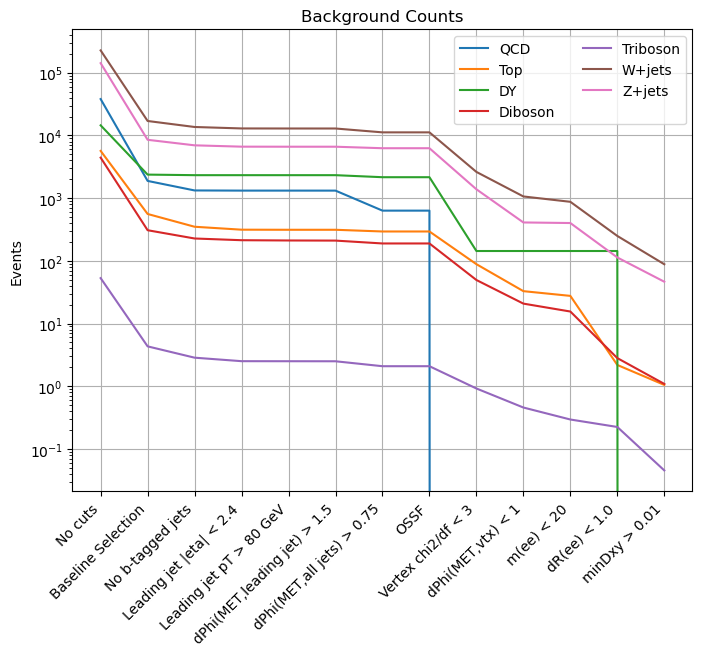

In [14]:
# bkg counts summed over sub-samples
plt.figure(figsize=(8,6))
plt.title("Background Counts")
for b in bkg['cutflow'].keys():
    cfbs = tot_bkg_cts[b]
    cts = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(cts)),cts,label=b)
    #plt.ylim([1e-12,1])
plt.yscale('log')
plt.ylabel('Events')
plt.legend(loc='upper right',ncol=2)
plt.grid()
plt.xticks(ticks=np.arange(len(cuts)),labels=[cutNames[c] for c in cuts],rotation=45,ha='right')
plt.savefig(f"plots/cutflows/bkg_combined_counts.pdf")

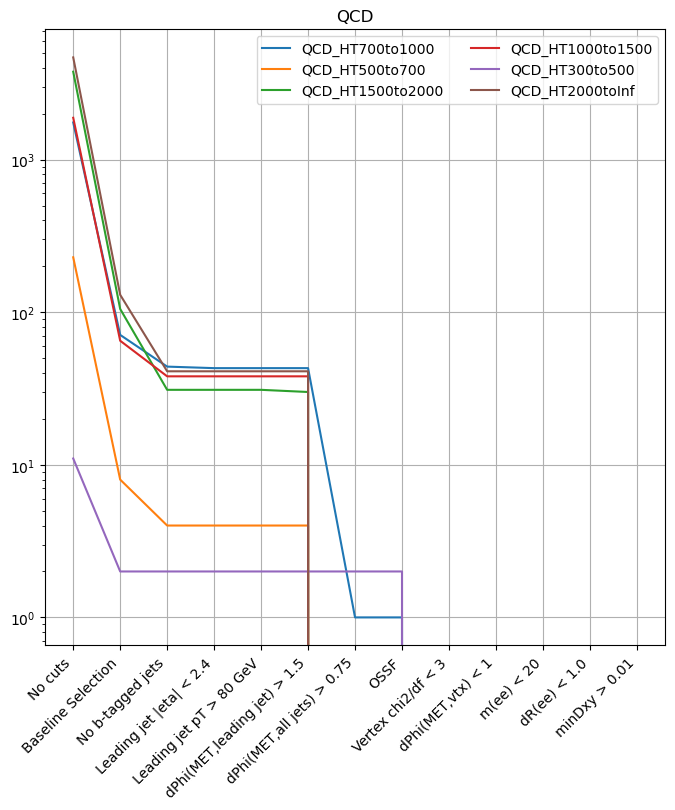

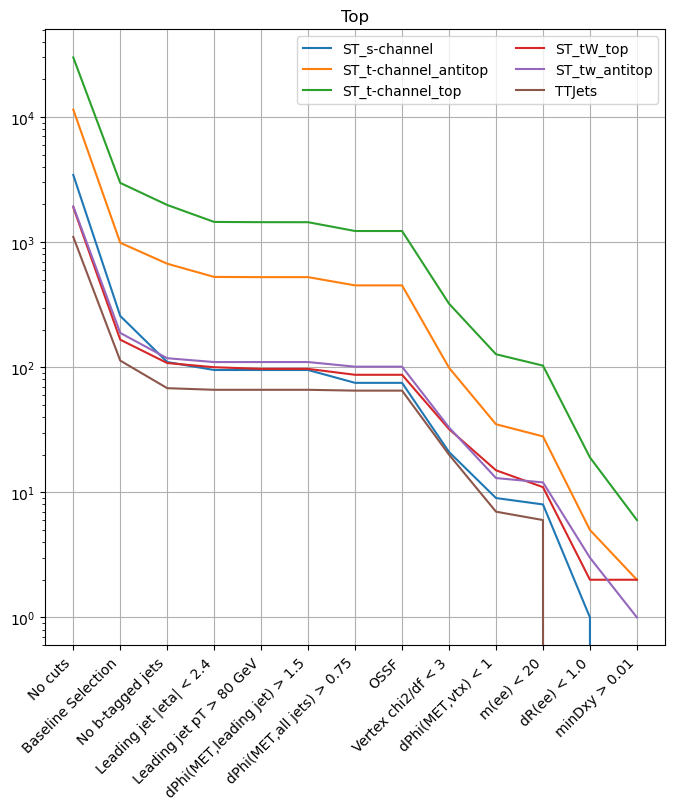

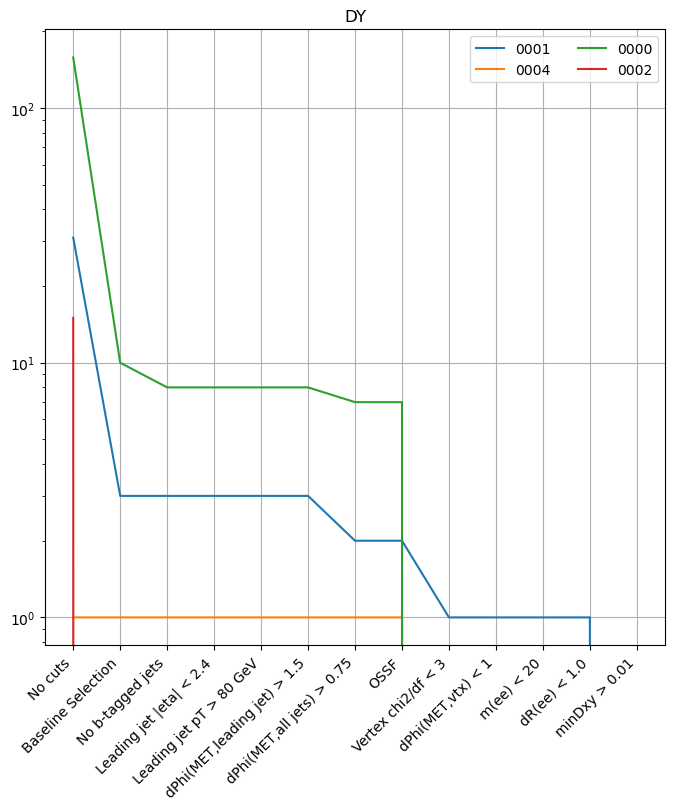

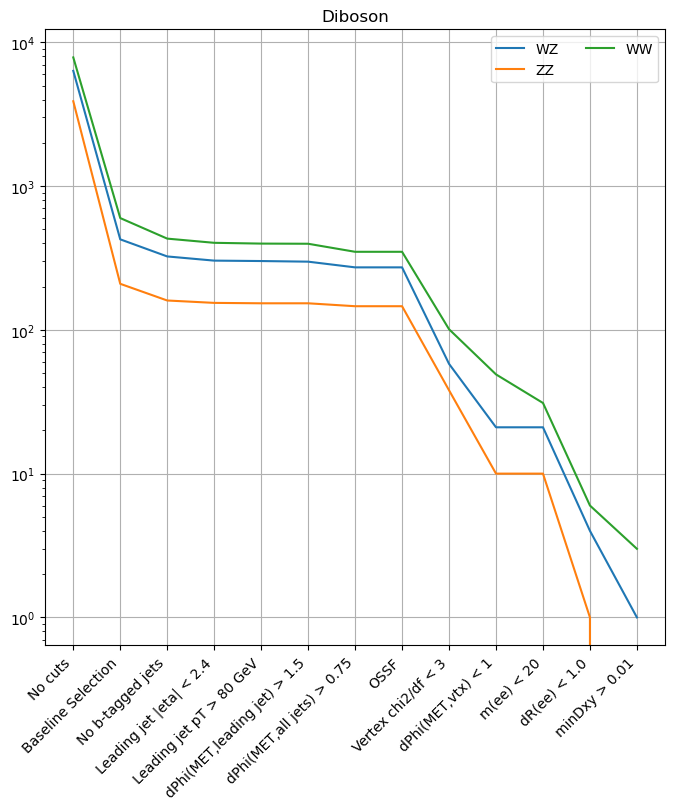

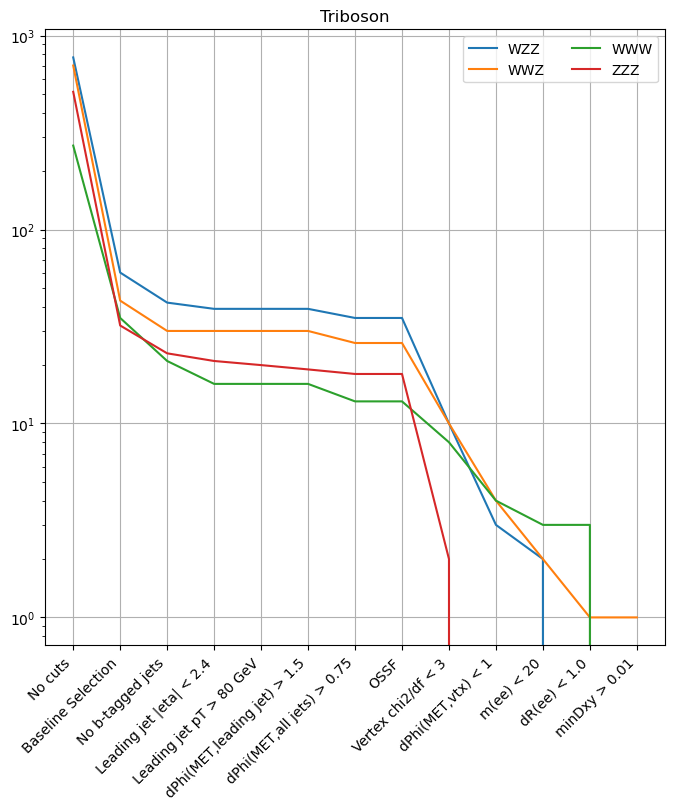

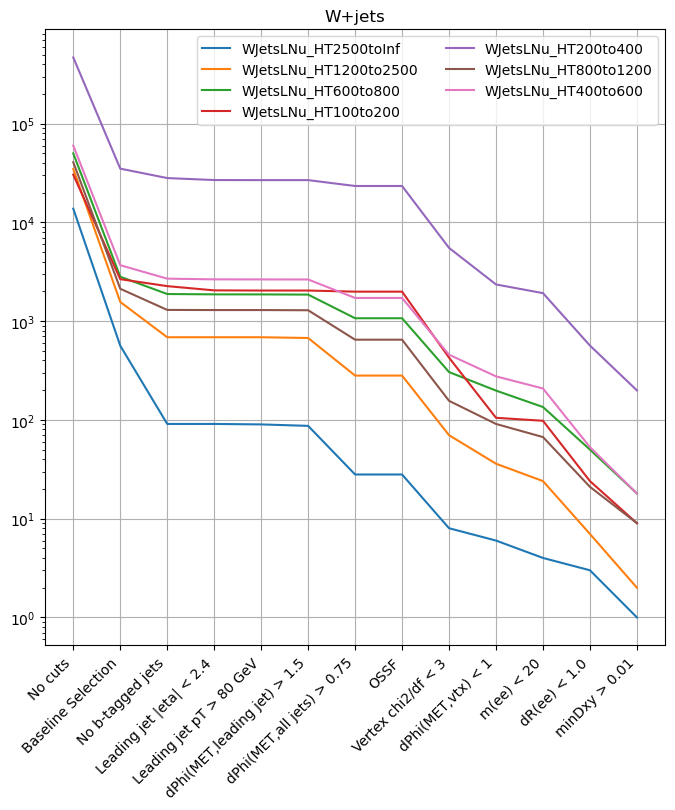

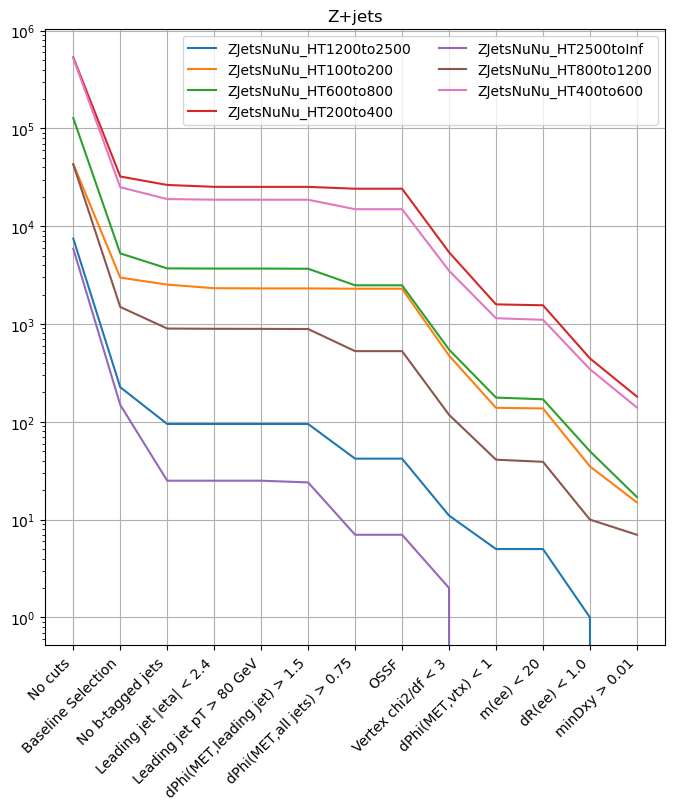

In [15]:
# bkg nevts
for b in bkg['cutflow'].keys():
    cfbs = bkg['cutflow_nevts'][b]
    plt.figure(figsize=(8,8))
    plt.title(b)
    subsamples = list(cfbs.keys())
    for bkg_pt in subsamples:
        cf = cfbs[bkg_pt]
        effs = [cf[c] for c in cuts]
        plt.plot(np.arange(len(effs)),effs,label=bkg_pt[9:])
    #plt.ylim([1e-12,1])
    plt.yscale('log')
    plt.legend(loc='upper right',ncol=2)
    plt.grid()
    #plt.xlabel("Cut Number")
    plt.xticks(ticks=np.arange(len(cuts)),labels=[cutNames[c] for c in cuts],rotation=45,ha='right')
    plt.savefig(f"plots/cutflows/bkg_{b}_nevts.pdf")
    #plt.close()

# signal vs bkg

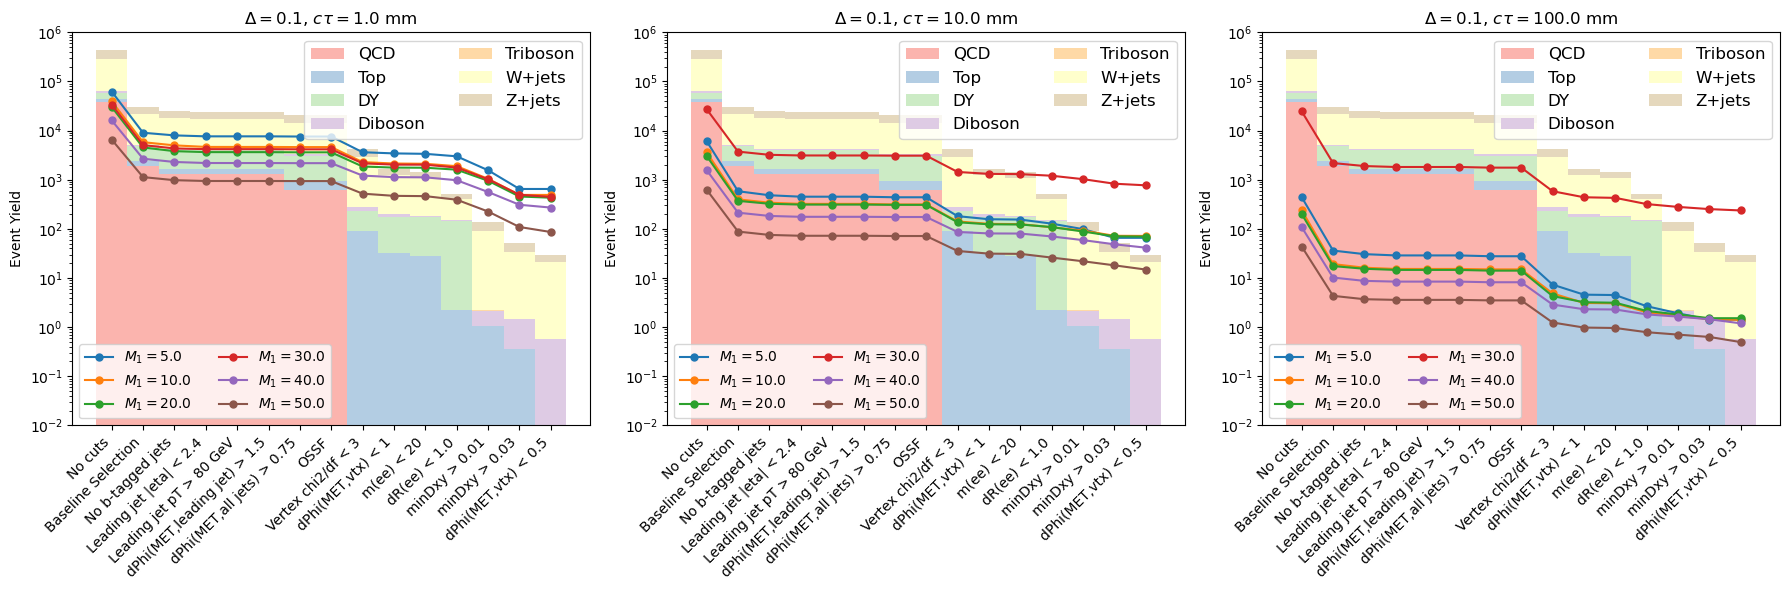

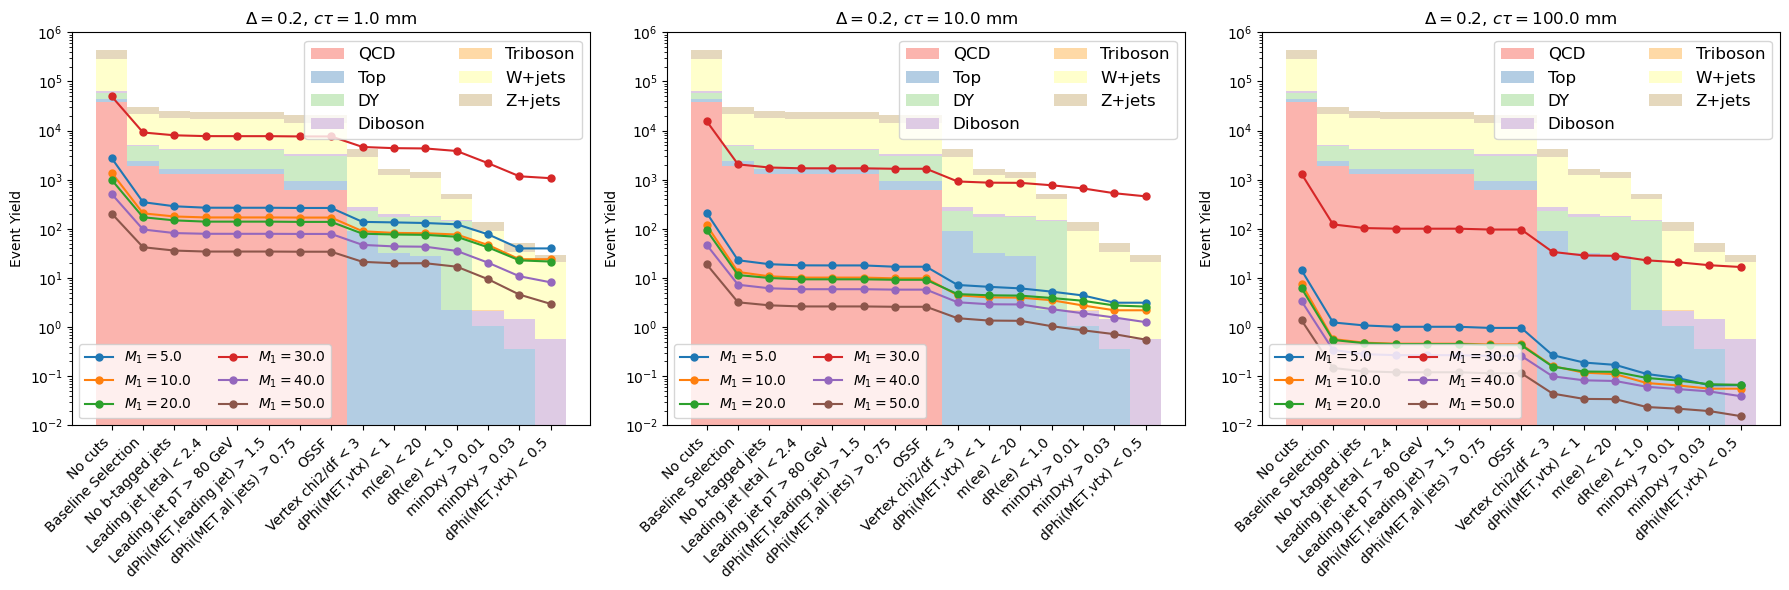

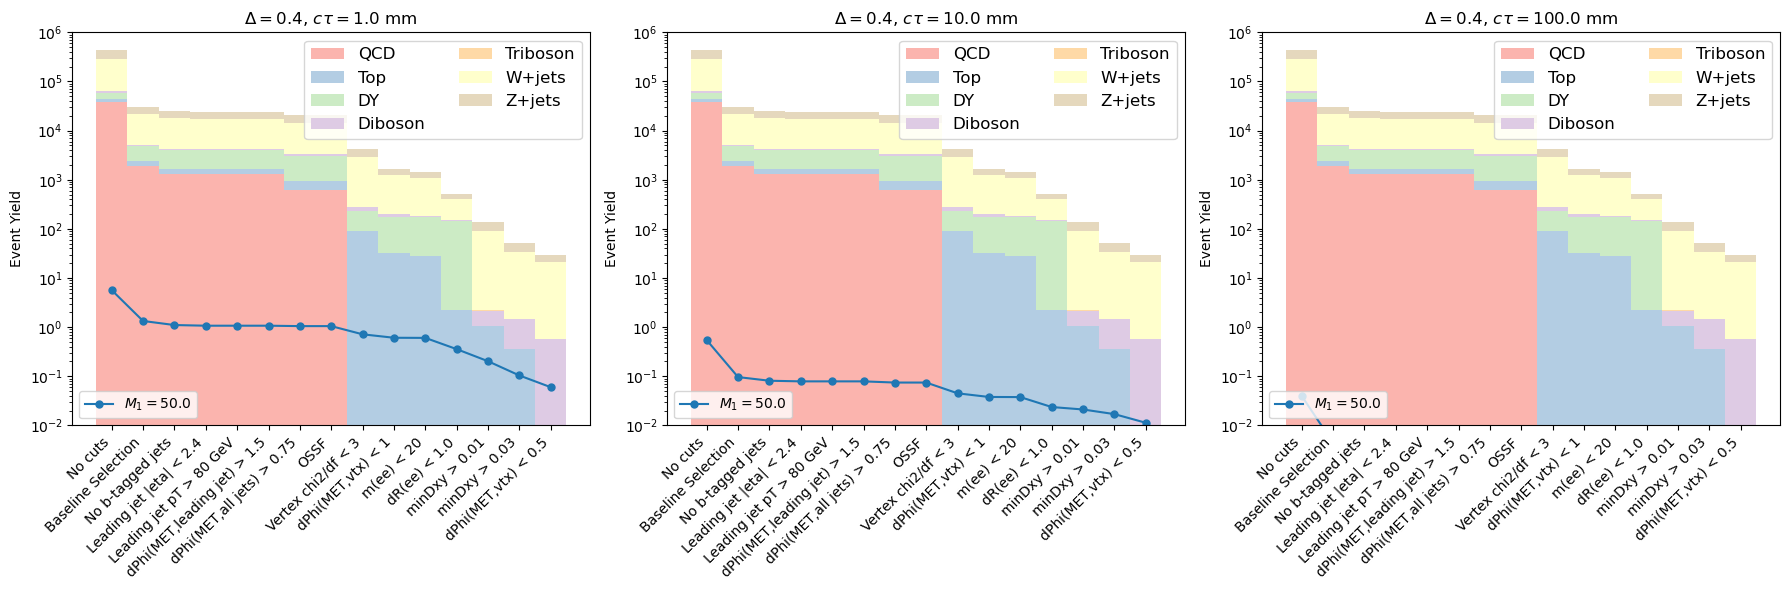

In [11]:
backgrounds = list(tot_bkg_cts.keys())

for delta in deltas:
    all_m1s = sorted(list(set(si[si.delta==delta].m1)))
    ctaus = sorted(list(set(si[si.delta==delta].ctau)))
    fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        bkg_labels = []
        bkg_heights = []
        bottoms = np.array([0.0 for c in cuts])
        cmap = plt.get_cmap('Pastel1')
        bars = []
        for j,b in enumerate(backgrounds):
            heights = [tot_bkg_cts[b][c] for c in cuts]
            x = np.arange(len(cuts))
            bars.append(plt.bar(x,heights,width=1,align='center',bottom=bottoms,color=cmap(j)))
            bottoms += np.array(heights)
        leg1 = plt.legend(bars,backgrounds,loc='upper right',fontsize=12,ncol=2)
        ax = plt.gca().add_artist(leg1)
        
        plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
        lines = []
        m1s = sorted(list(set(si[(si.delta==delta)&(si.ctau==ct)].m1)))
        for m1 in m1s:
            if m1 > 50:
                continue
            pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
            effs = [sig['cutflow_cts'][pt][cut] for cut in cuts]
            l, = plt.plot(np.arange(len(cuts)),effs,label=r"$M_1 = {0}$".format(m1),marker='.',markersize=10)
            lines.append(l)
        plt.legend(handles=lines,loc='lower left',ncol=2)
        plt.ylim([1e-2,1e6])
        #plt.xlim([3,11])
        plt.yscale('log')
        plt.ylabel("Event Yield")
        #plt.xlabel("Cut Number")
        plt.xticks(ticks=np.arange(len(cuts)),labels=[cutNames[c] for c in cuts],rotation=45,ha='right')
        #plt.grid()
    plt.tight_layout()
    plt.savefig(f"plots/cutflows/signal_vs_itemizedBkg_counts_delta{delta:.1f}.pdf")
    #plt.close()

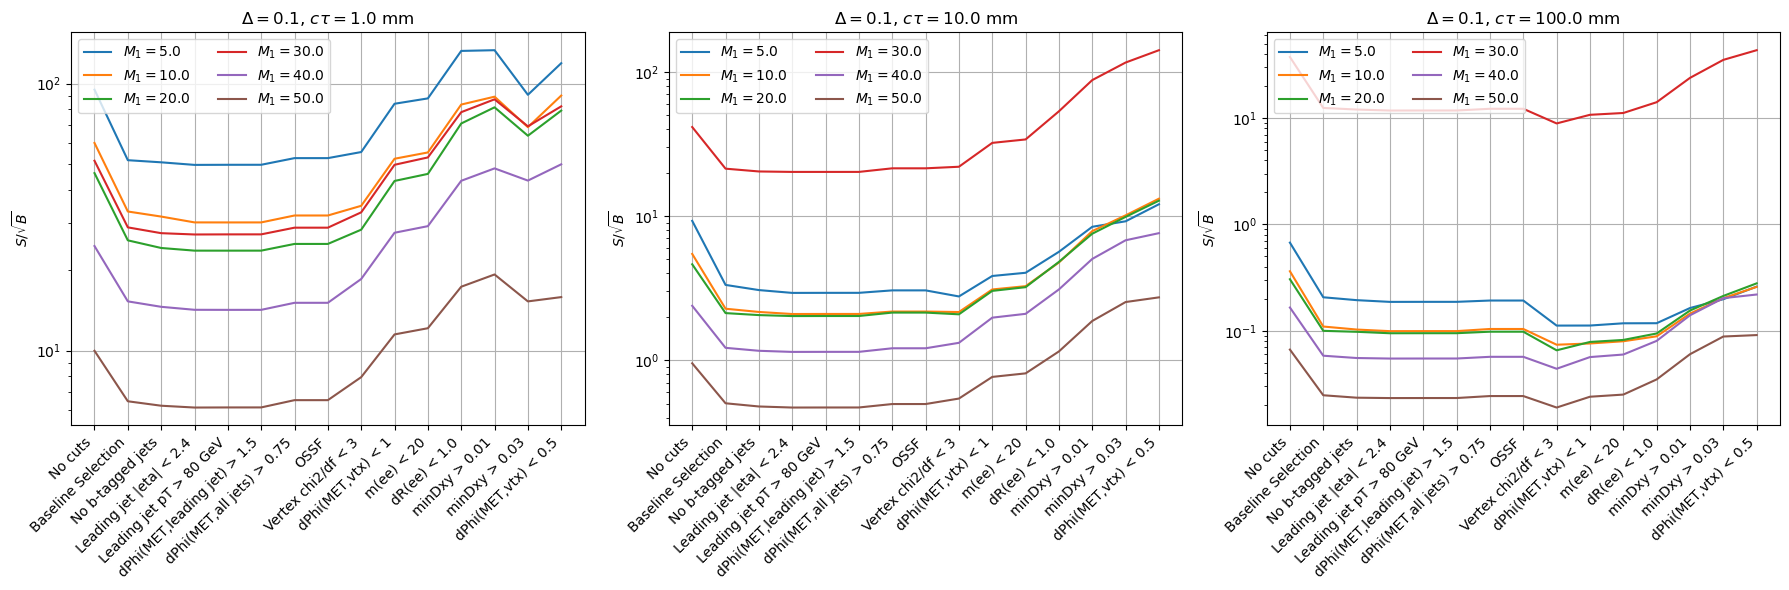

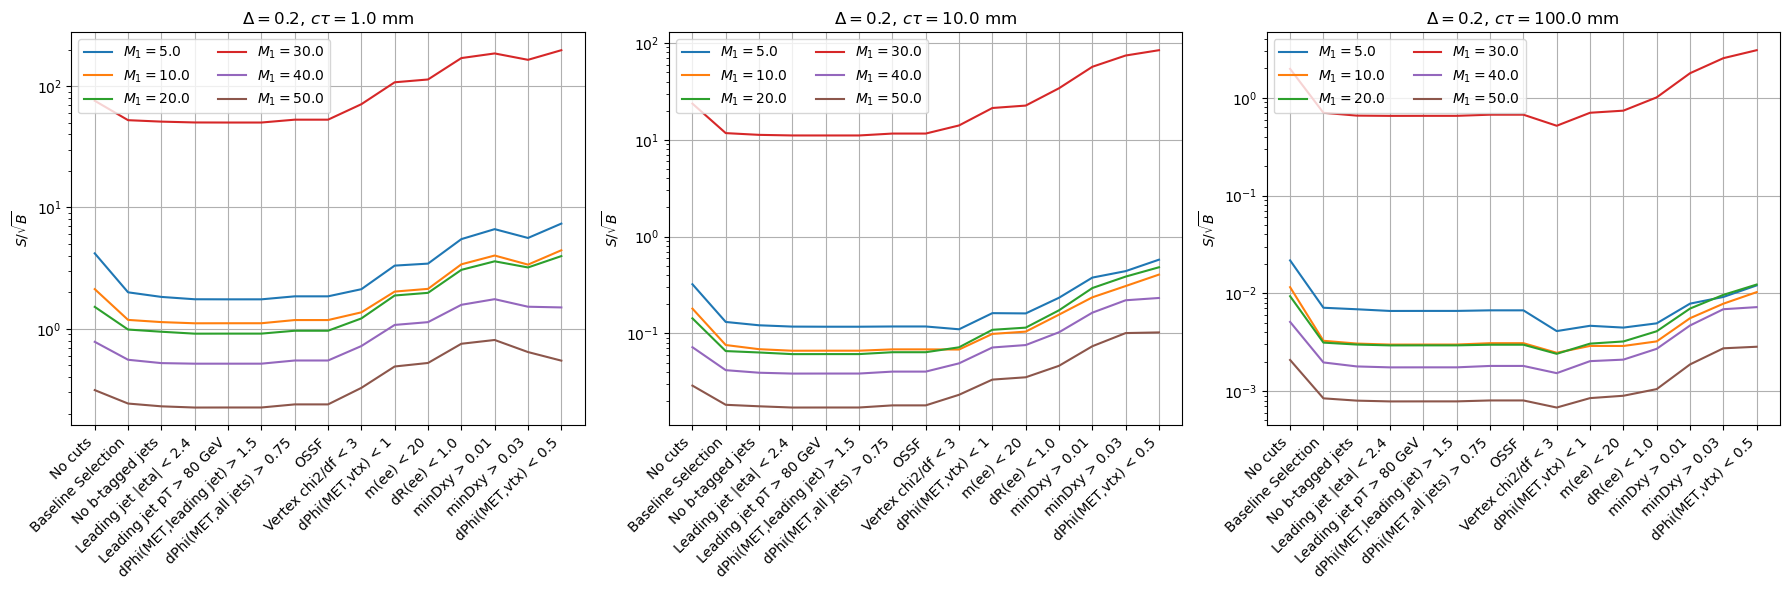

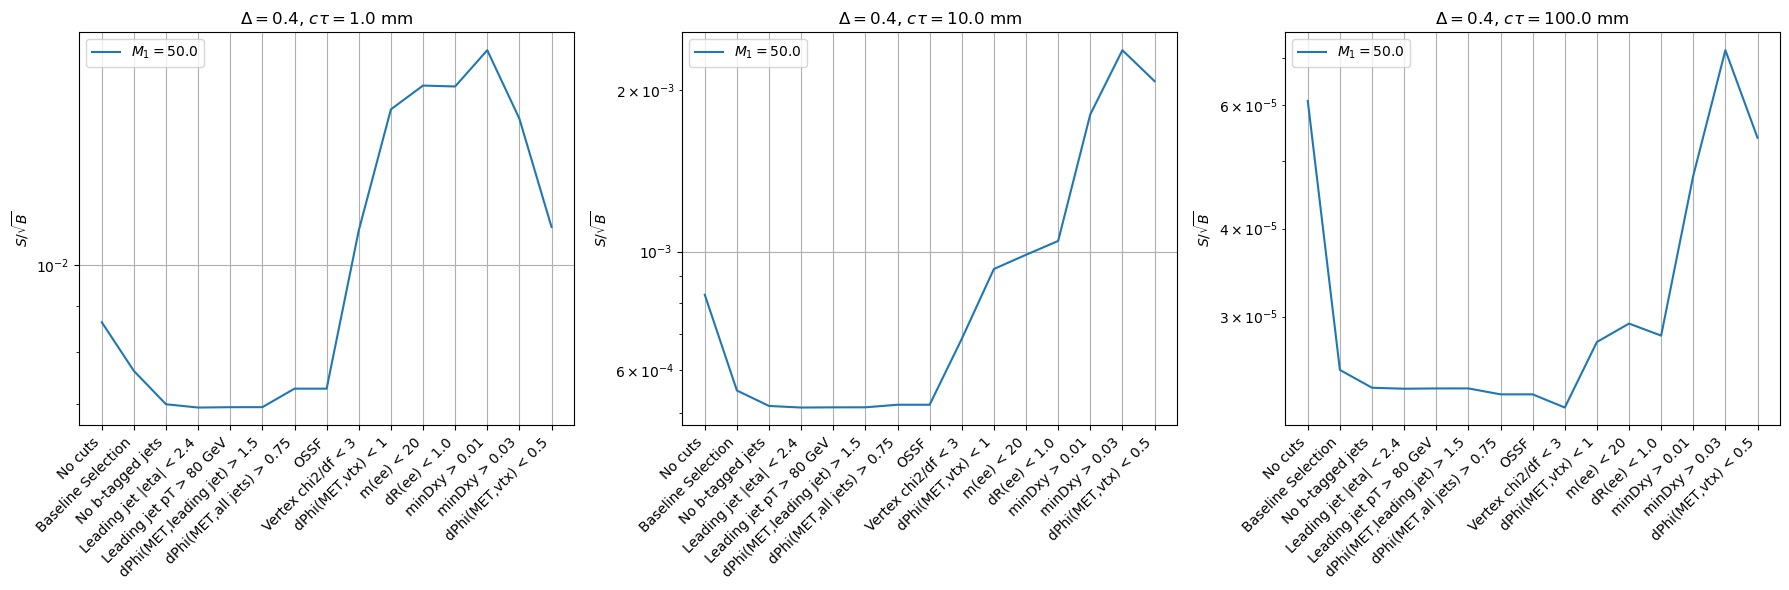

In [12]:
# S/sqrt(B)
cf_s = sig['cutflow']
ct_s = sig['cutflow_cts']
desc = sig['cutDesc']
for delta in deltas:
    all_m1s = sorted(list(set(si[si.delta==delta].m1)))
    ctaus = sorted(list(set(si[si.delta==delta].ctau)))
    fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
        m1s = sorted(list(set(si[(si.delta==delta)&(si.ctau==ct)].m1)))
        for m1 in m1s:
            if m1 > 50:
                continue
            pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
            effs = [ct_s[pt][cut]/np.sqrt(bkg_summed_cts[cut]) for cut in cuts]
            plt.plot(np.arange(len(cuts)),effs,label=r"$M_1 = {0}$".format(m1))
        plt.legend(loc='upper left',ncol=2)
        #plt.ylim([1e-5,1e2])
        #plt.xlim([3,11])
        plt.yscale('log')
        plt.ylabel(r"$S/\sqrt{B}$")
        #plt.xlabel("Cut Number")
        plt.xticks(ticks=np.arange(len(cuts)),labels=[cutNames[c] for c in cuts],rotation=45,ha='right')
        plt.grid()
    plt.tight_layout()
    plt.savefig(f"plots/cutflows/signal_signif_delta{delta:.1f}.pdf")
    #plt.close()